### Standard & Poor's (S&P 500 index):
#### Preprocessing.
#### EDA
#### Transformations
#### ML models 
#### Feature Engineering
#### NN's

### Importing Libraries 

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import holidays
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor



import warnings # filter warnings
warnings.filterwarnings('ignore')

The selected source for the experiment is Yahoo Finance, through the integration of the yfinance library and jupyter.
- Timeframe selected for the project is 10 years (2014-2023).
- The frequency to be used is business day, the selection is because the market is open during these days.
- The period include real world scenarios such as Brexit in 2016 and Covid-19.
- Is also believed that in 10 years of data, volatility and trends are present in the market.

The last trading day 2013 is also being imported due to critical importante in some of the approaches.

#### Importing dataset from yahoo finance (yfinance library).

In [2]:
# Defines ticker symbol for S&P 500 index.
ticker_symbol = "^GSPC"

# Fetch historical data.
sp500_data = yf.download(ticker_symbol, start="2013-12-31", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


The command display provides an overview of the dataset: 
- Head: First five rows.
- Tail: Last five rows.
- Shape: Number of rows and columns.

#### Data PreProcessing 

In [3]:
display(sp500_data)

Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-12-31  1842.609985  1849.439941  1842.410034  1848.359985  1848.359985   
2014-01-02  1845.859985  1845.859985  1827.739990  1831.979980  1831.979980   
2014-01-03  1833.209961  1838.239990  1829.130005  1831.369995  1831.369995   
2014-01-06  1832.310059  1837.160034  1823.729980  1826.770020  1826.770020   
2014-01-07  1828.709961  1840.099976  1828.709961  1837.880005  1837.880005   
...                 ...          ...          ...          ...          ...   
2023-12-22  4753.919922  4772.939941  4736.770020  4754.629883  4754.629883   
2023-12-26  4758.859863  4784.720215  4758.450195  4774.750000  4774.750000   
2023-12-27  4773.450195  4785.390137  4768.899902  4781.580078  4781.580078   
2023-12-28  4786.439941  4793.299805  4780.979980  4783.350098  4783.350098   
2023-12-29  4782.879883  4788.430176  4751.990234  4769.830078  4769.830078   

                Volume  
Date                    
2013-12-31  2312840000  
2014-01-02  3080600000  
2014-01-03  2774270000  
2014-01-06  3294850000  
2014-01-07  3511750000  
...                ...  
2023-12-22  3046770000  
2023-12-26  2513910000  
2023-12-27  2748450000  
2023-12-28  2698860000  
2023-12-29  3126060000  

[2517 rows x 6 columns]

- The dataset is composed by 2517 rows and 6 features. In this present project the Close feature will be the focus of the study, representing the closing index at the end of the trading day.

In [4]:
# Check for missing values
missing_values = sp500_data.isnull().sum()

# Print the number of missing values for each column
print("Missing values:")
print(missing_values)

Missing values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


- The S&P 500 index dataset imported from yfinance is composed by 2517 observations and 6 features.

The dataset does not present outliers at this point. However, by observind the first five rows it is noticeable that there are not five days in a row (business days), therefore holidays on weekdays might have been excluded from the set due to no trading activity.

In [5]:
# Define start and end dates - 10 years period.
start_date = '2013-12-31'
end_date = '2023-12-31'

# Generate business days between the start and end dates
business_days = pd.bdate_range(start=start_date, end=end_date)

# Get the total number of business days
total_business_days = len(business_days)

print("Total number of business days between", start_date, "and", end_date, "is:", total_business_days)

Total number of business days between 2013-12-31 and 2023-12-31 is: 2609


The calendar within the selected period has 2609 business days, having more days than the number of rows in the dataset, providing more evidence for the exclusion of holidays on weekdays (no trading). 
- weekends could be considered noise (market is closed).
- by analysing just the business days it can be focused on days that the market is actually open, reducing the amount of noise which could affect the model performance. 

<b> After the models have being implemented a second round of models can be applied using daily frequency, which will include all the seven days (addition not only of holidays on weekdays, but also, weekends).

- Check the performance of the models and compare what frequency techniques performs better or worse. In addition, check if the introduction of noise (handling missing values) affected the models and justify even deeper the choice for the frequency.

In [6]:
# Defining start and end dates (ten years timeframe)
start_date = date(2013, 12, 31)
end_date = date(2023, 12, 31)

# Get all US business holidays between start_date and end_date
us_holidays = holidays.US()

# Create a complete date range covering all weekdays
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# Filter out holidays that fall on weekdays
us_business_holidays = [holiday for holiday in us_holidays.keys() if holiday in all_weekdays]

# Filter out weekends
weekdays = all_weekdays.difference(pd.to_datetime(us_business_holidays))

# Create DataFrame with all weekdays
weekdays_df = pd.DataFrame({'Date': weekdays})

# Set 'Date' column as index
weekdays_df.set_index('Date', inplace=True)

# Create DataFrame with S&P 500 data
df = pd.DataFrame(sp500_data, columns=['Close'])

# Merge the two DataFrames on the index
merged_df = weekdays_df.merge(df, left_index=True, right_index=True, how='left')

# Convert back to Series
df_BF = merged_df

# Display the updated Series
display(df_BF)

Close
Date                   
2013-12-31  1848.359985
2014-01-01          NaN
2014-01-02  1831.979980
2014-01-03  1831.369995
2014-01-06  1826.770020
...                 ...
2023-12-25          NaN
2023-12-26  4774.750000
2023-12-27  4781.580078
2023-12-28  4783.350098
2023-12-29  4769.830078

[2609 rows x 1 columns]

- After the inputation of the holidays the number of entries match with the total (2608), which was generated by the previous code.
- The inputed missing days were added with NaN values, which will have to be addressed. 

In [7]:
# Check for missing values
missing_values = df_BF.isnull().sum()

# Print the number of missing values for each column
print("Missing values:")
print(missing_values)

Missing values:
Close    92
dtype: int64


In [8]:
# Checking if there's any consecutive missing values in the Close indexes. 
# Converting NaN checks to integers (1 for True, 0 for False).
nan_series = df_BF['Close'].isna().astype(int)

# Rolling window size 3 and sum to identify consecutive NaNs
consecutive_nans = nan_series.rolling(window=3).sum() == 3

# Check for any occurrence of more than two consecutive NaNs
has_consecutive_nans = consecutive_nans.any()

print(f"Two consecutive NaNs in 'Close' column? {has_consecutive_nans}")


Two consecutive NaNs in 'Close' column? False


- Since there are no consecutive missing values, linear regression methods might not be the best option.

During this 10 years period, the market had 92 holidays on business days.
<b> Assuming that technically the close value of the last trading day will maintain untill the following trading day.

Since the main focus of the project is the Close column, many options can be applied to fill the missing values (holidays) and each one of them having a trade off of pros and cons. Techniques using the next opening to fill the previous, linear regression and others (depending on the performance).
The selected approach to handle the missing values is the foward fill and the reasons relies on: 
- The S&P500 index does not suffers any change when the market is closed;
- It can reduce the amount of noise by not adding artificial data;
- It represents more accurate real-world scenario;

The rationales were thought out to perform time-series analysis (forecasting) with the dataset. 

Other options such as back-fill using the open index of the next day could be considered. On one hand can present events that might impact the stock market, on the other hand it can introduce bias to the models, by "seing" future data. 

In [9]:
# Forward fill NaN values in the 'Close' column.
df_BF.fillna(method='ffill', inplace=True)

# Display the updated DataFrame with forward filled values.
display(df_BF)

Close
Date                   
2013-12-31  1848.359985
2014-01-01  1848.359985
2014-01-02  1831.979980
2014-01-03  1831.369995
2014-01-06  1826.770020
...                 ...
2023-12-25  4754.629883
2023-12-26  4774.750000
2023-12-27  4781.580078
2023-12-28  4783.350098
2023-12-29  4769.830078

[2609 rows x 1 columns]

In [10]:
# Check for missing values
missing_values = df_BF.isnull().sum()

# Print the number of missing values for each column
print("Missing values:")
print(missing_values)

Missing values:
Close    0
dtype: int64


In [11]:
sp500_data['Close'].describe()

count    2517.000000
mean     3005.423258
std       901.454132
min      1741.890015
25%      2124.199951
50%      2798.030029
75%      3906.709961
max      4796.560059
Name: Close, dtype: float64

In [12]:
df_BF.describe()

Close
count  2609.000000
mean   3005.472863
std     901.733128
min    1741.890015
25%    2124.199951
50%    2793.899902
75%    3902.620117
max    4796.560059

Looking at the statistical properties of the S&P500 data (withouy any imputations) and the df_BF (with imputations), it is observable that the properties barely changed, the biggest difference are in the 50% (-4.13) and 75% (-4.09). However, taking into consideration the scale the change is not significant. 

The statistical features of the imputed dataframe, the df_BF:
- The variable ranges from 1741.89 to 4796.56
- It has a mean (average) of 3005.92.
- The standard deviation is 901.62, and in the present context can be considered high because it represents almost 30% of the avg value, but also, taking into consideration the scale of the min and max values. 

Other imputation techniques can be applied later to check the results and implications of each approach to handle the missing values.

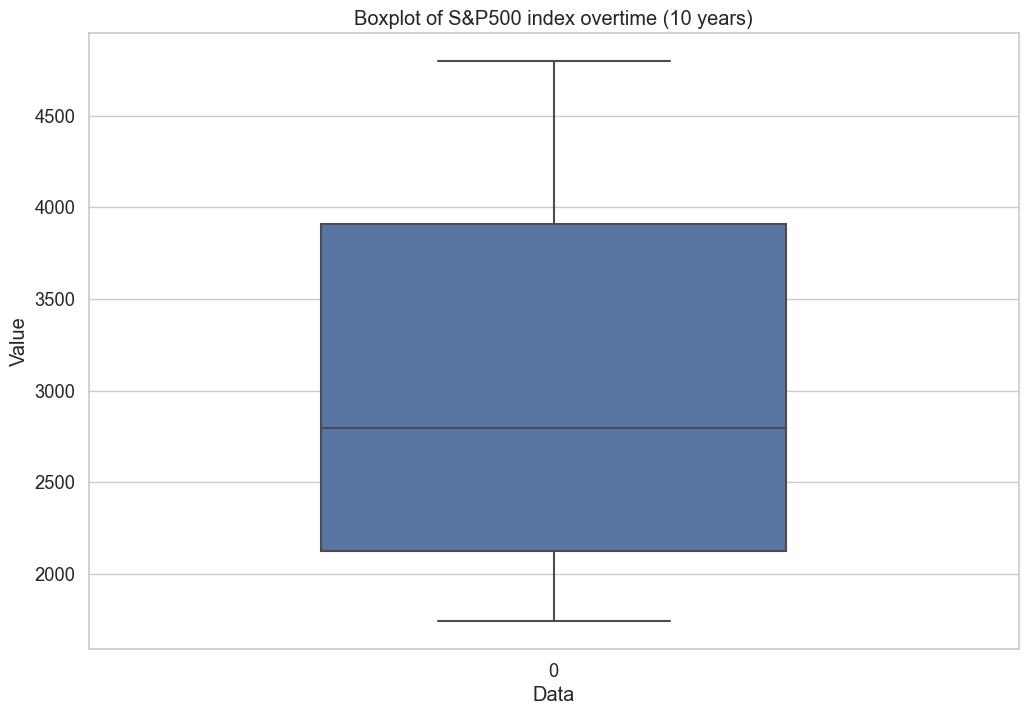

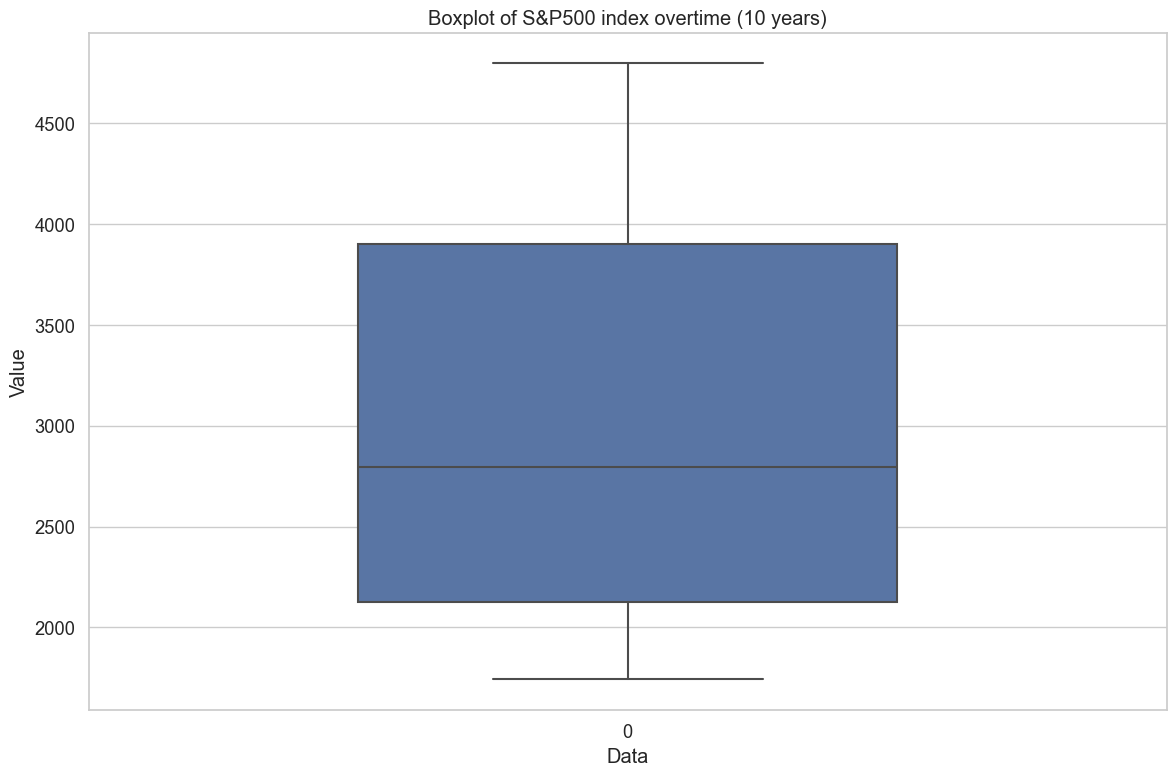

In [13]:
plt.figure(figsize=(12, 8)) # Set up the plot and adjust the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Add a whitegrid in the backgound for clear visualization.
# Creates the boxplot with all the columns.
ax = sns.boxplot(data=sp500_data['Close'], width=0.5) # Sets the width to 0.5
 # Add labels and ha argument used to align the labels to the designated boxplot.
ax.set_xlabel('Data') # Adds x-axis label.
ax.set_ylabel('Value') # Adds y-axis label.
ax.set_title('Boxplot of S&P500 index overtime (10 years)') # Sets title to tle boxplot.

plt.figure(figsize=(12, 8)) # Set up the plot and adjust the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Add a whitegrid in the backgound for clear visualization.
# Creates the boxplot with all the columns.
ax = sns.boxplot(data=df_BF['Close'], width=0.5) # Sets the width to 0.5
 # Add labels and ha argument used to align the labels to the designated boxplot.
ax.set_xlabel('Data') # Adds x-axis label.
ax.set_ylabel('Value') # Adds y-axis label.
ax.set_title('Boxplot of S&P500 index overtime (10 years)') # Sets title to tle boxplot.

plt.tight_layout() # Adjusts the layout.
plt.show() # Shows the plot.

- The .describe along with the boxplot shows that the mean is above the median indicating a skewness towards higher values.
- According to the boxplot, the close variable does not present any values outside of the skewers, which might indicate that outliers are not present. Although, tests can be performed after checking the distribution of the data.
- Also between the original dataset and with imputed "business days" barely suffered any changes when looking at the boxplots

### Distribution of Close index

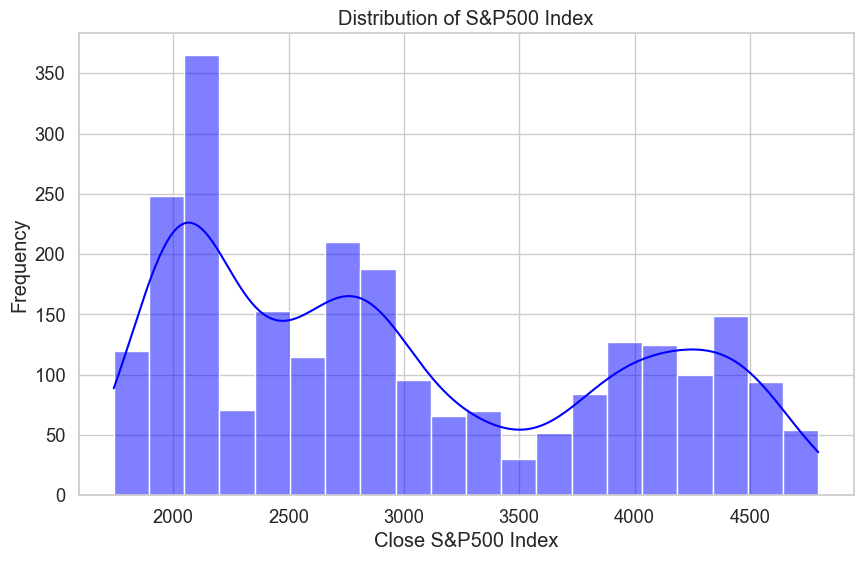

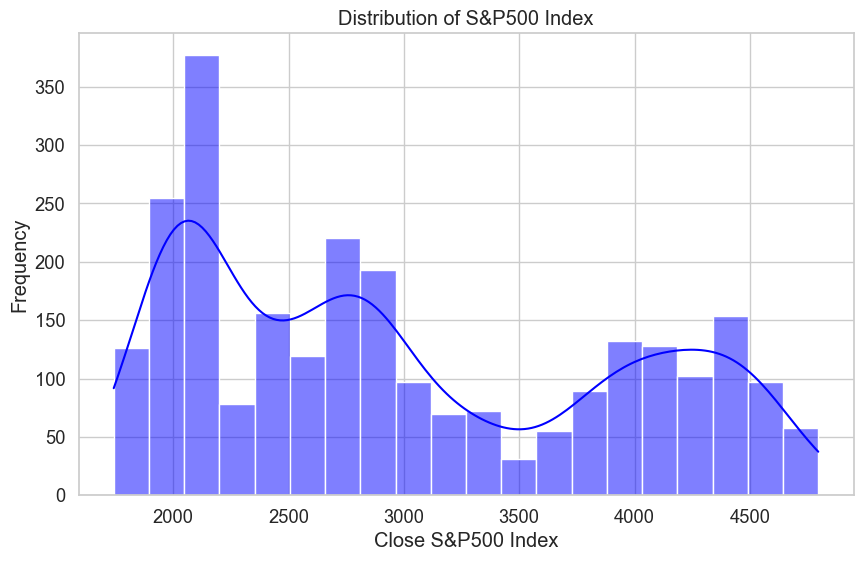

In [14]:
# Distribution plot of Close prices
plt.figure(figsize=(10, 6))
sns.histplot(sp500_data['Close'], bins=20, kde=True, color='blue')
plt.title('Distribution of S&P500 Index')
plt.xlabel('Close S&P500 Index')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_BF['Close'], bins=20, kde=True, color='blue')
plt.title('Distribution of S&P500 Index')
plt.xlabel('Close S&P500 Index')
plt.ylabel('Frequency')
plt.show()

- The distribution of the data has not change from the original to the inputted business days (holiday).
- The S&P 500 index presents a multimodal distribution of values, in its distribution plot and the KDE curve shows three different peaks. Despite trying different number of bins, multiple peaks were still present.

The assumption to be followed is that the data has a multimodal distribution. In addition, to the non-linearity, which will represent a challenge for linear models such as ARIMA and SARIMA.

#### Outliers and Skewness

Based on the distribution, standard test such as IQR, MAD, Z-Score cannot be considered appropriate.
- The IQR method to identify outliers does not fit this case, because is indicated for unimodal distributions.
- Z-score, follows the same assumption as the IQR.
- The MAD, the three different peaks could indicate that are values clustered around them. Thus, this method could generate misleading results.

- Outliers will be also be analysed during the seasonal decompose stage. 

#### S&P 500 index overtime

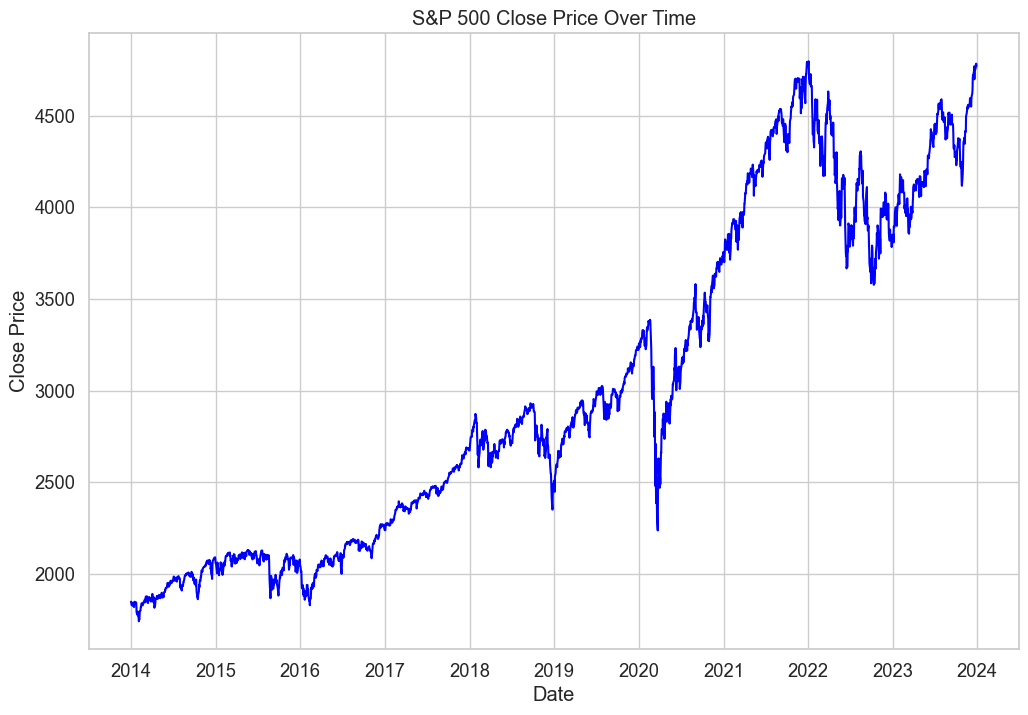

In [15]:
# Plotting
plt.figure(figsize=(12, 8))

# Time Series Plot of Close Price
plt.plot(df_BF.index, df_BF['Close'], color='blue')
plt.title('S&P 500 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.show()

- The lineplot of the index overtime shows that has an upwards trend. More details will be explored in the seasonal decompose.

#### Seasonal Decompose at a different periods

Seasonal Decomposition with Period = 252


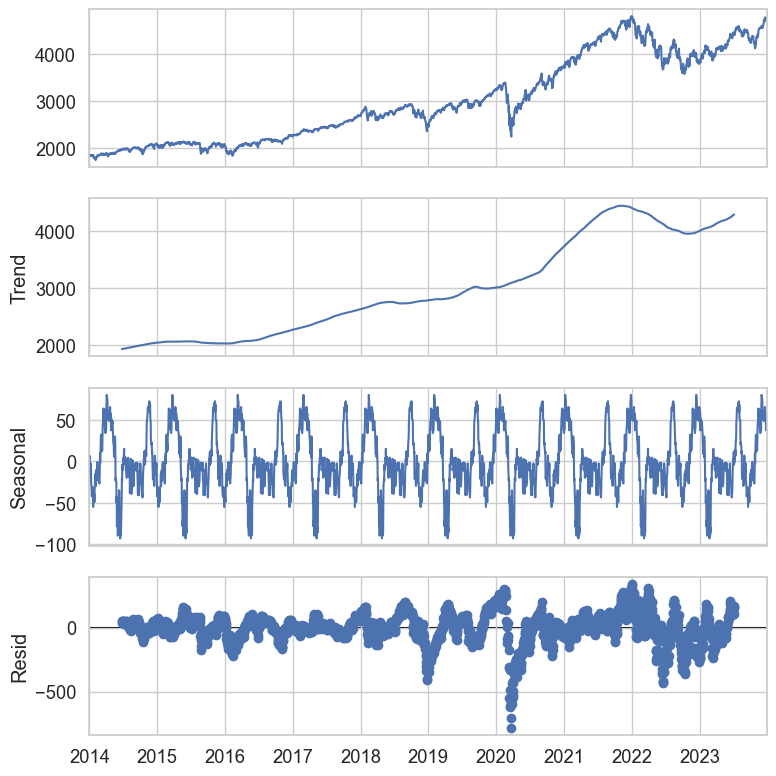

Seasonal Decomposition with Period = 126


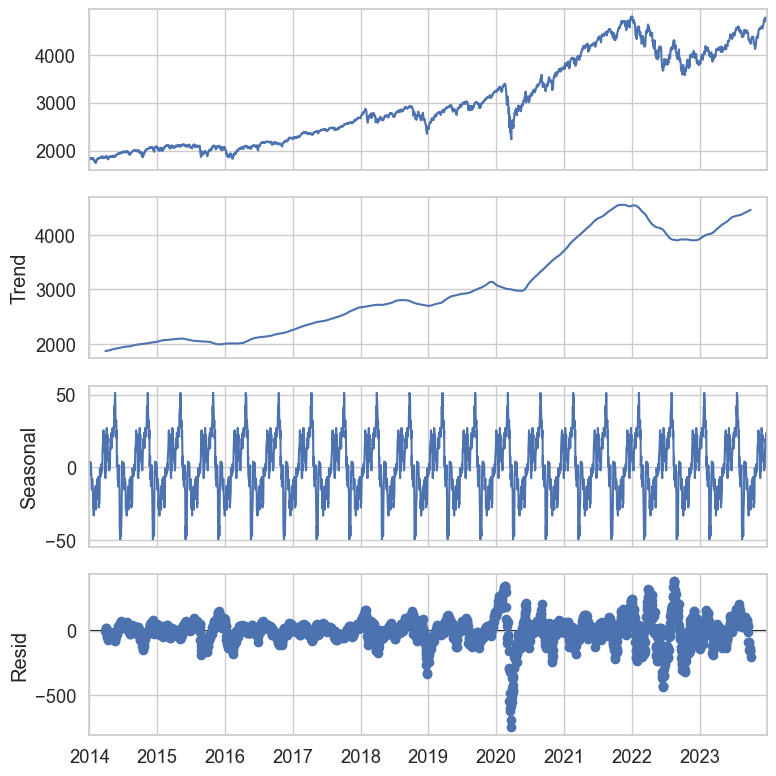

Seasonal Decomposition with Period = 63


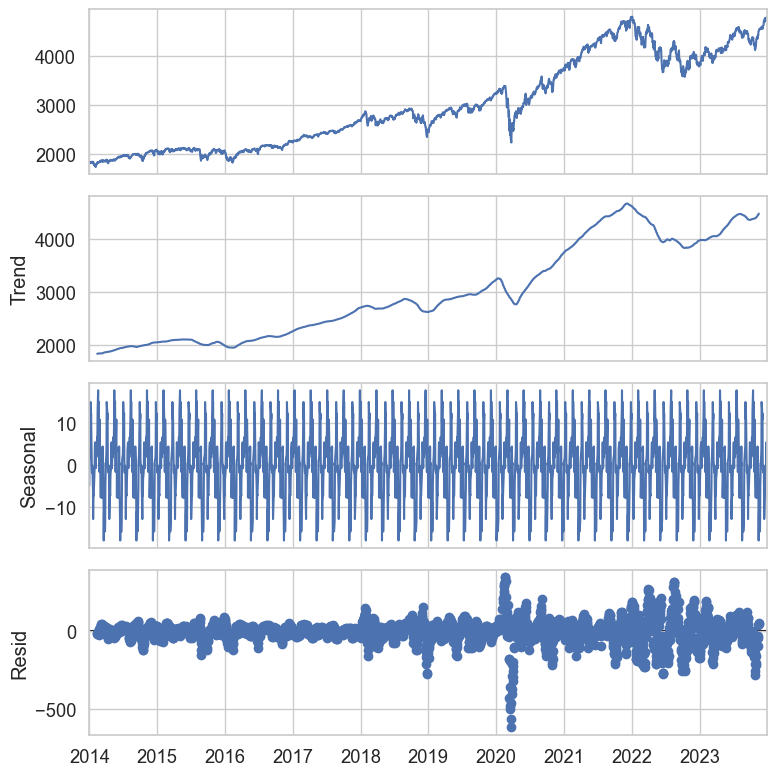

Seasonal Decomposition with Period = 21


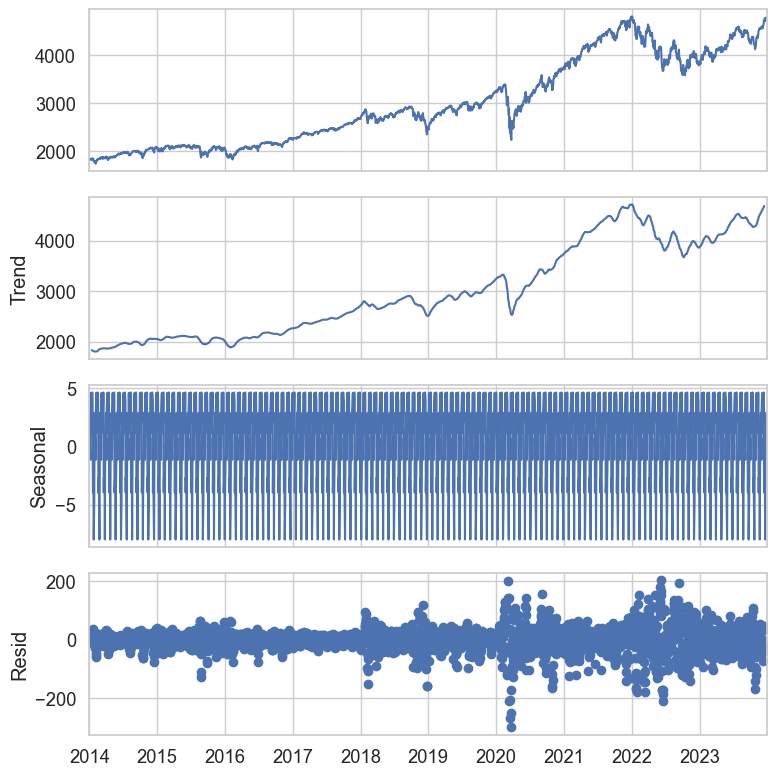

In [16]:
# Seasonal decompositions with different periods.
periods = [252, 126, 63, 21]  # Annual, Six months, Quartely, Monthly (assuming business days)
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df_BF, model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

- By performing the seasonal decompose using different periods, all periods showed similiar trend (upwards) and seasonality. However, by lowering the period the number of residuals increased, which could indicate high complexity or non-linearity in the data.

Analysing the seasonal decomposition of different periods: 

- Trend: As observed in the lineplot, the index has an upward trend overtime.
- Seasonality: The plot shows that it has a pattern that repeats overtime.
- Residuals: The figure indicates that the data has a lot of noise, but no pattern was indentified.

Due to the results of the residual plot a deeper look into the noises/outliers will be performed, they present a big threat on time-series models performance. 

#### S&P 500 Seasonal Decompose Residual Analysis at different periods

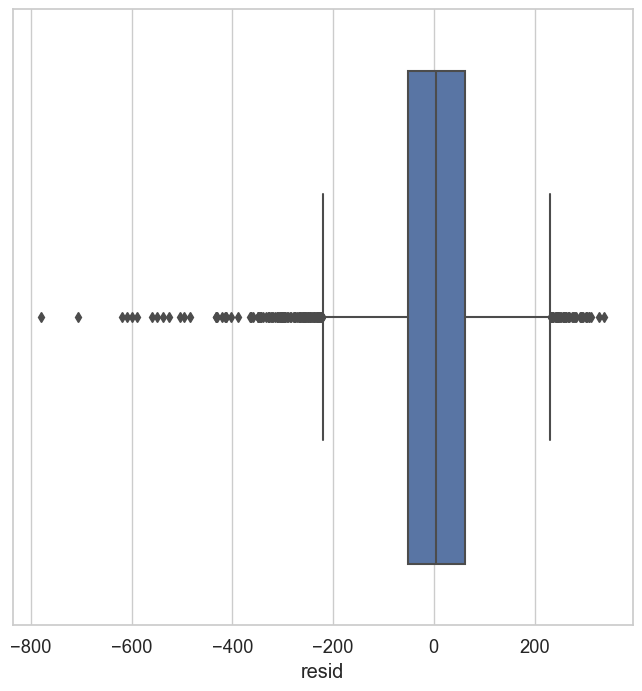

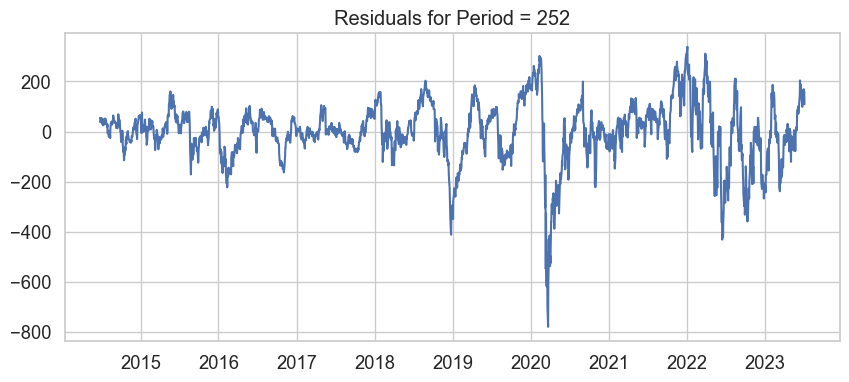

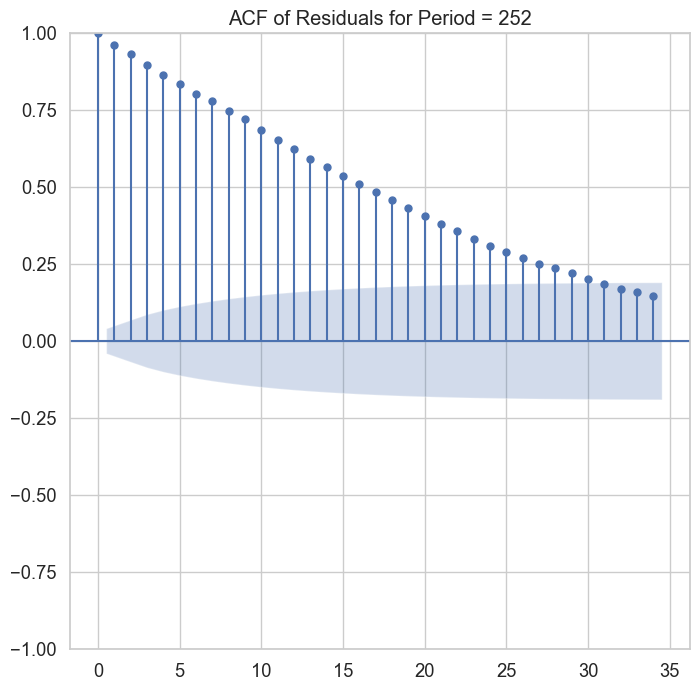

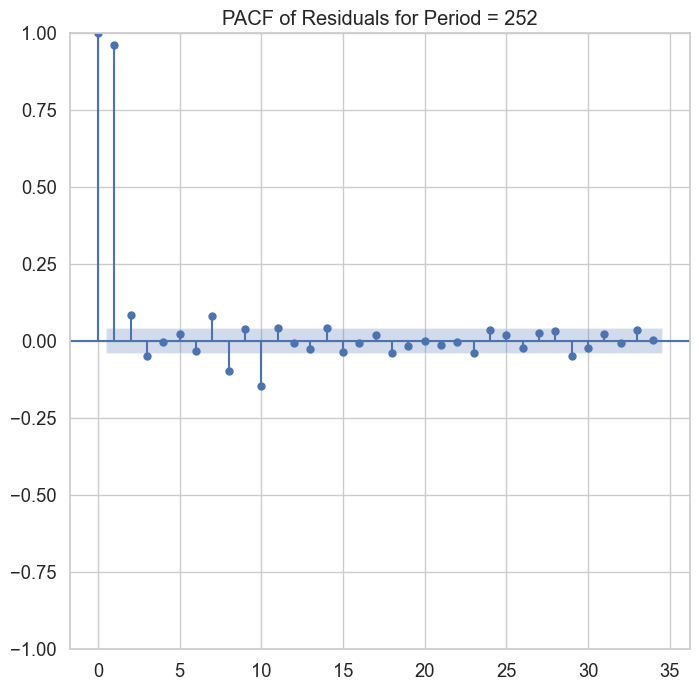

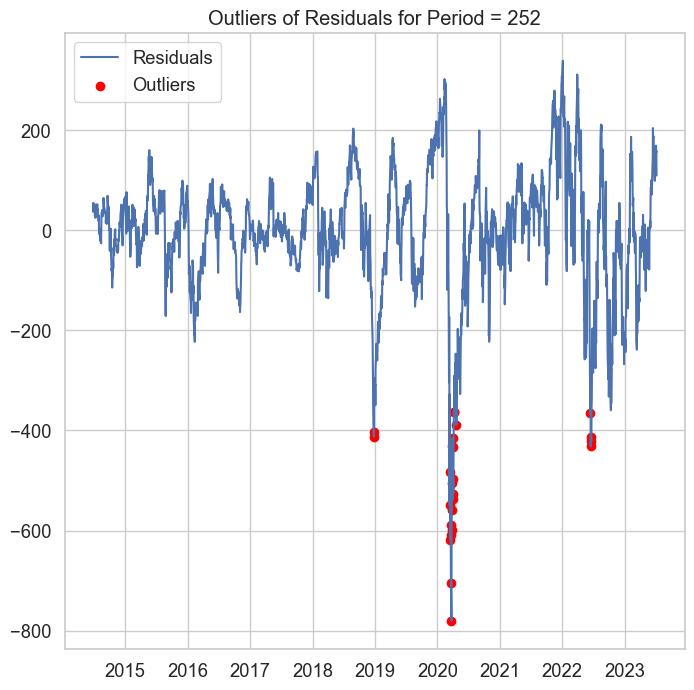

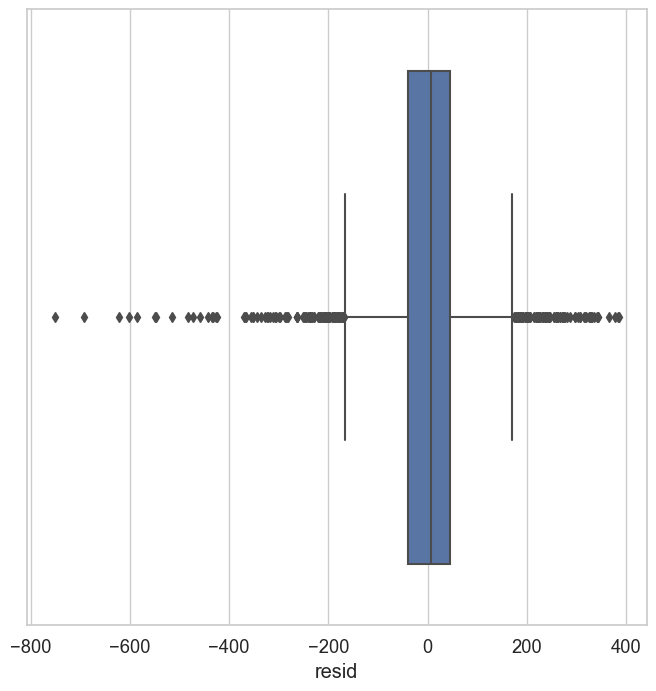

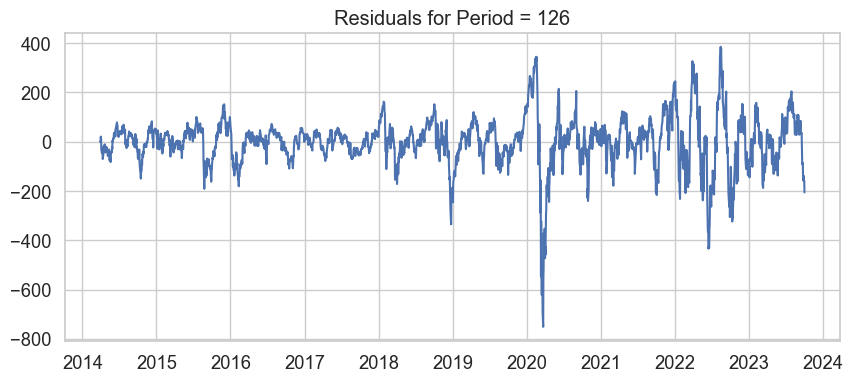

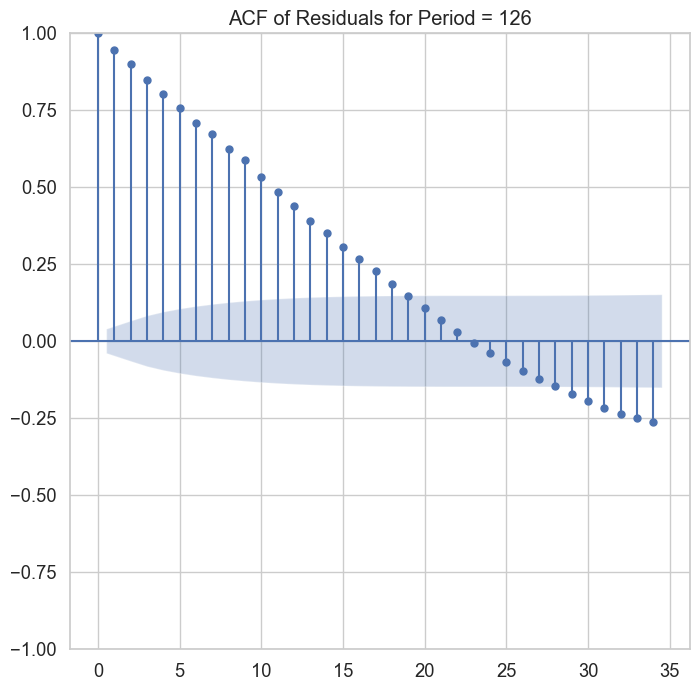

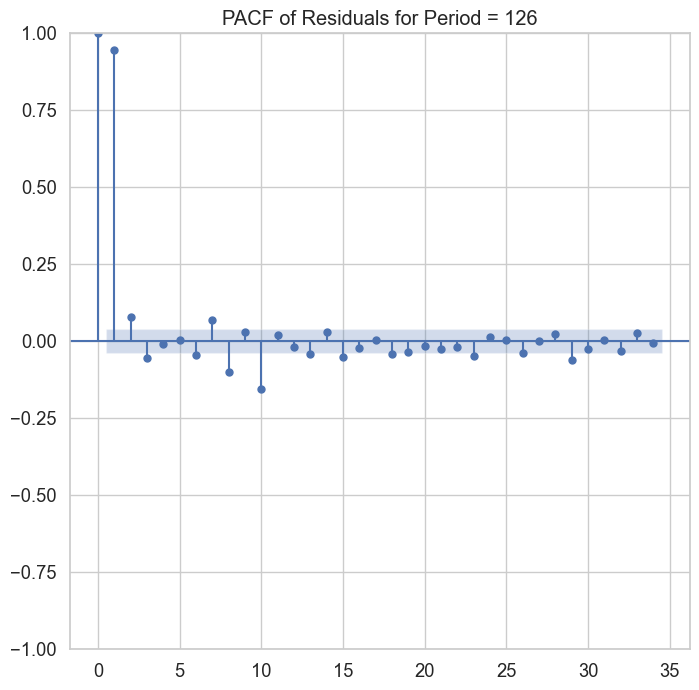

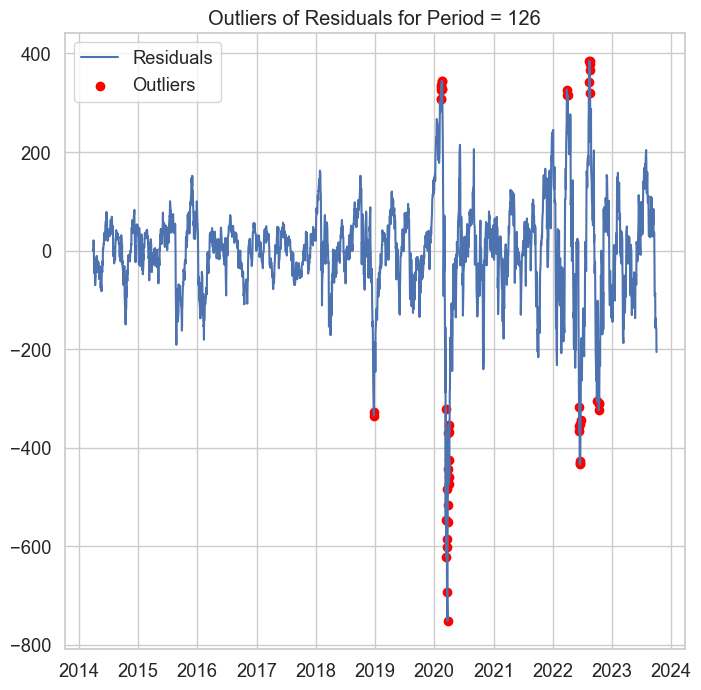

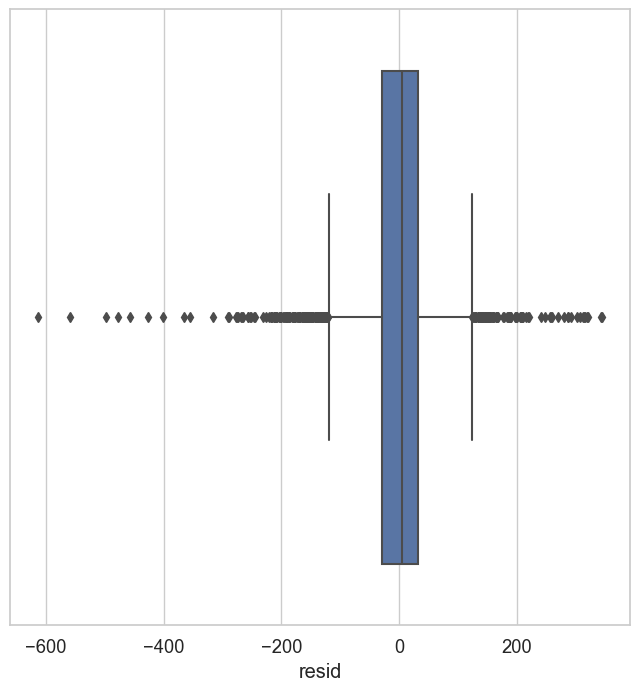

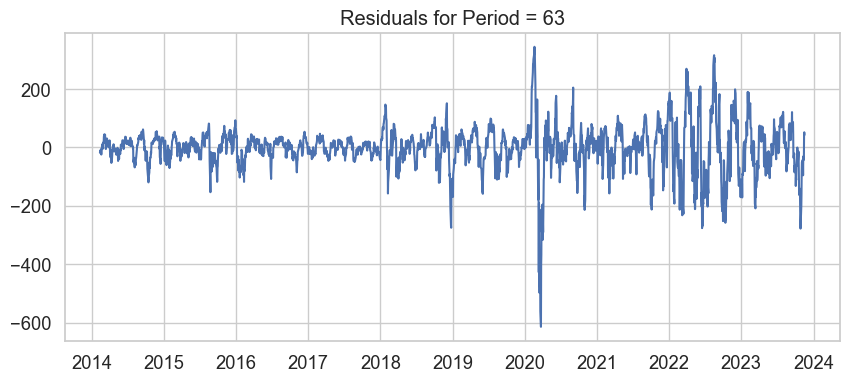

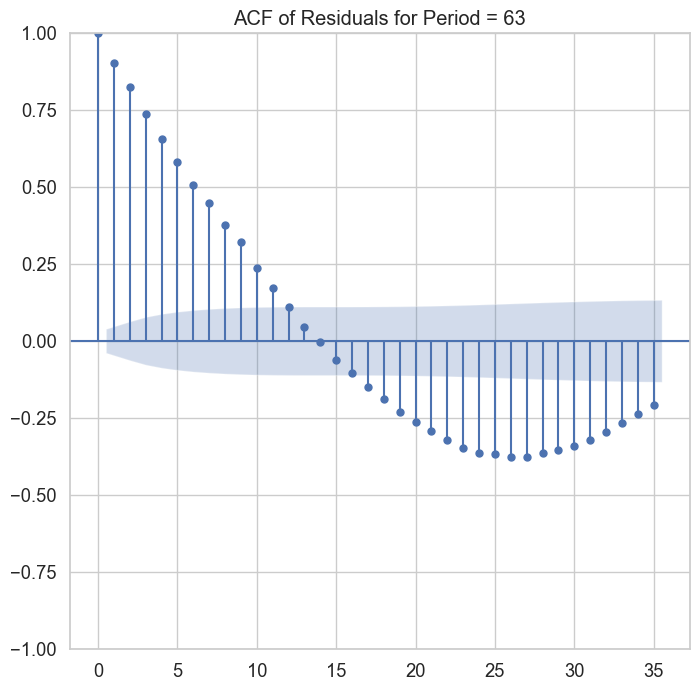

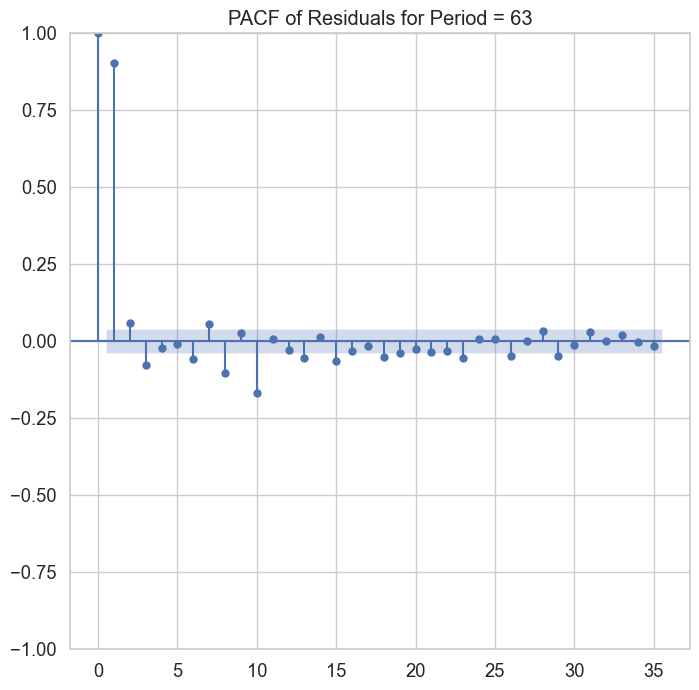

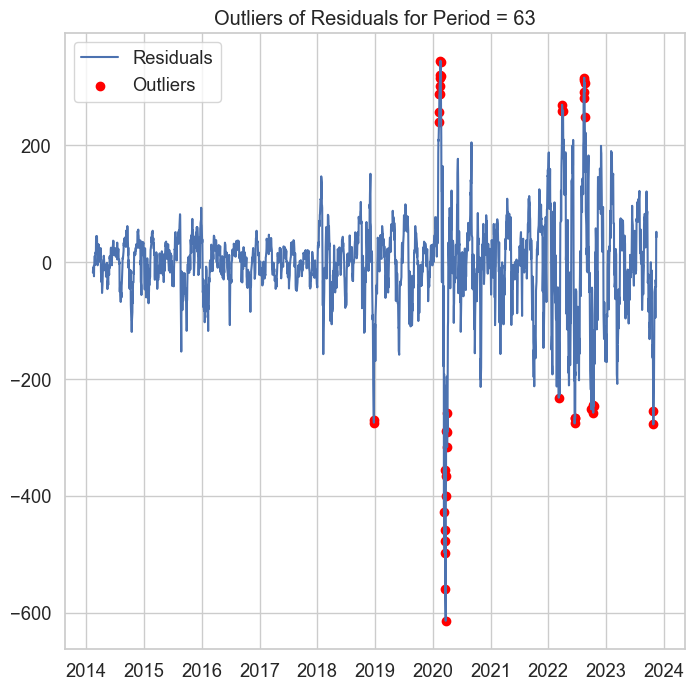

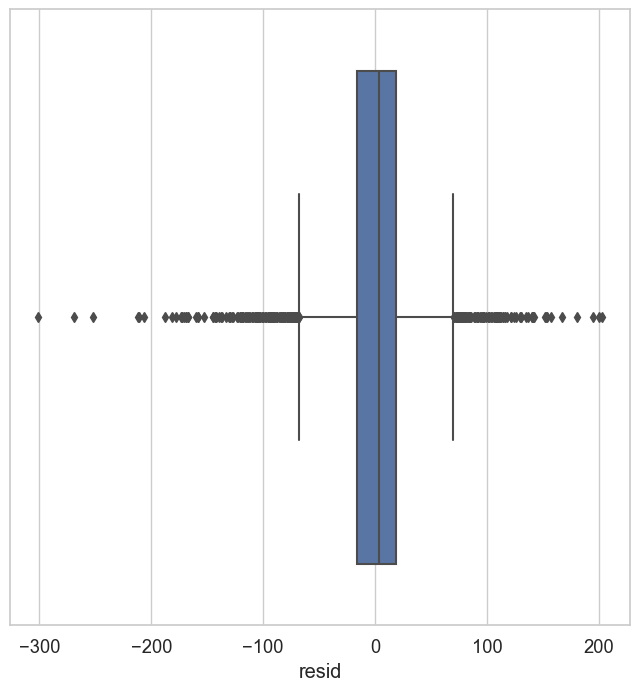

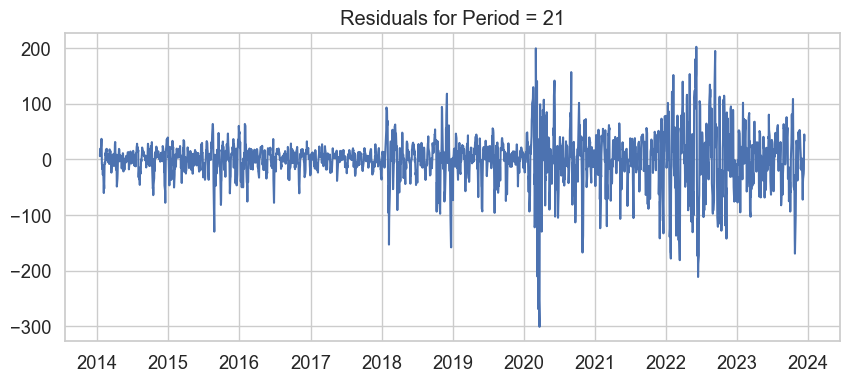

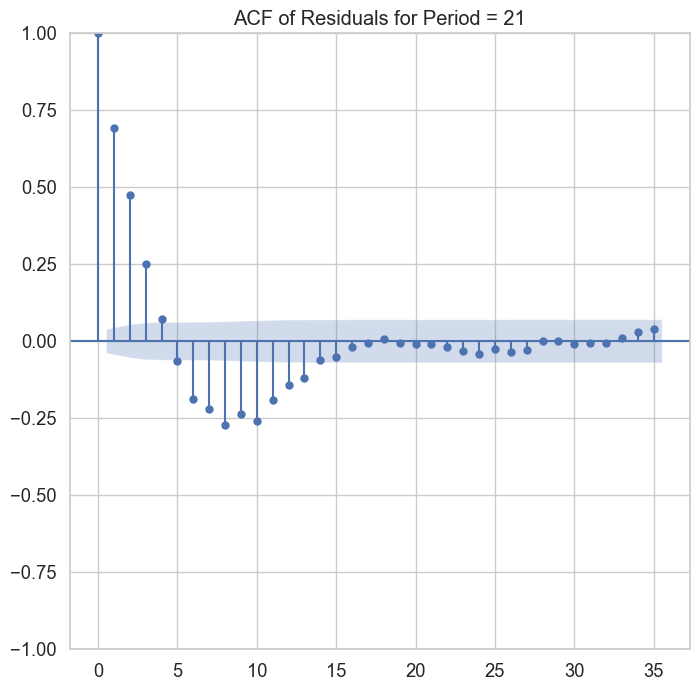

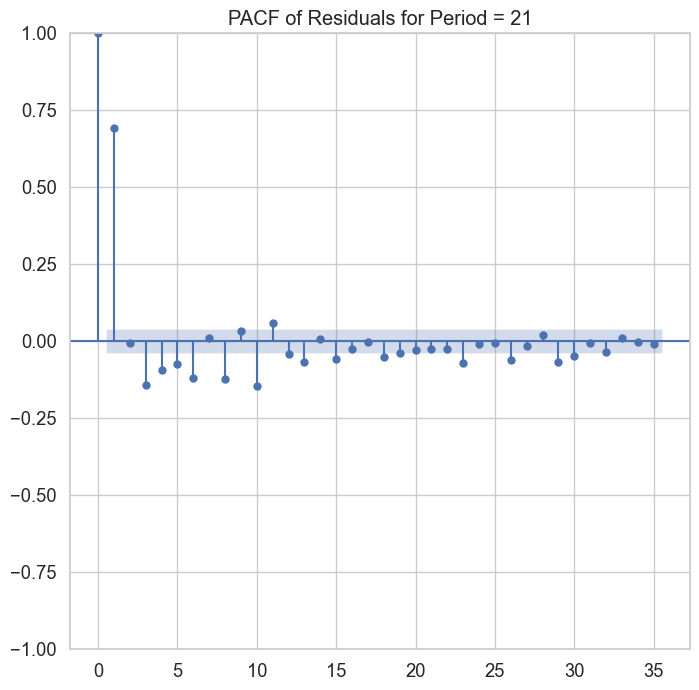

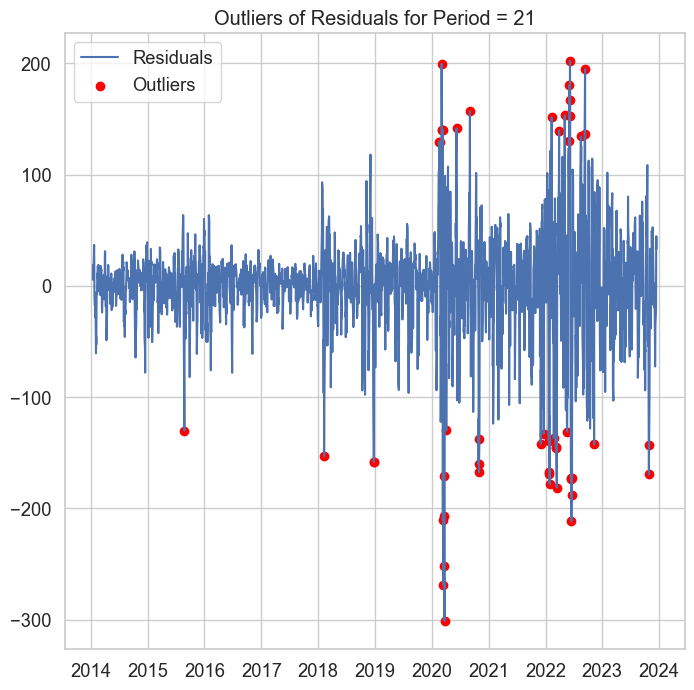

In [17]:
periods = [252, 126, 63, 21]  # Annual, Six months, Quarterly, Monthly

# Function for residual analysis for each period.
for period in periods:
    decomposition = seasonal_decompose(df_BF, model='additive', period=period)
    
    # Analyzing the residuals
    residuals = decomposition.resid.dropna()  # Dropping NA values which are a result of the decomposition process

    # Calculates statistical features. 
    residual_mean = residuals.mean()
    residual_std = residuals.std()

    # Identify potential outliers - points where the residual is more than 3 standard deviations from the mean.
    outliers = residuals[np.abs(residuals - residual_mean) > 3 * residual_std]

    # Create a box plot of the residuals
    sns.boxplot(x=residuals)
    
    # Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f'Residuals for Period = {period}')
    plt.show()

    # Autocorrelation plot of residuals
    plot_acf(residuals)
    plt.title(f'ACF of Residuals for Period = {period}')
    plt.show()
    
    # Partial autocorrelation plot of residuals
    plot_pacf(residuals)
    plt.title(f'PACF of Residuals for Period = {period}')
    plt.show()

    # Highlights points that are considered outliers on top of the time series.
    plt.plot(residuals, label='Residuals')
    plt.scatter(outliers.index, outliers, color='red', label='Outliers')
    plt.title(f'Outliers of Residuals for Period = {period}')
    plt.legend()
    plt.show()

#### Interpretation and Analysis of residuals at different periods (Year, Six-Months, Quarter, Month).

#### Boxplot of the residuals.
The boxplot of residuals shows that numerous data points are present on both side of the skewers (strongly indicating the presence of outliers) for all the four periods.

#### ACF.
The ACF residuals shows autocorrelation in all periods, but the quartely (63) period indicates a cyclical pattern. The correlation still remains at ix months (126), showing that future values are still being influenced by past values. However, in a year (252), after 30 lags it enters the interval confidence. 

#### PACF.
All four periods presented a great autocorrelation at the first lag, indicating that in models such as ARIMA, the AutoRegressive parameters of 1 can be a good start. 

#### Ouliers 
The plots shows red dots, which indicates outliers in the residuals, they are easily identified by the high volatility and how clustered they are during 2020, which was because of the Covid pandemic (external shocks).

The implications of this is that the selection of time series models need to be robust against outliers (or they will have to be handled), but also techniques like autoregressive models that can manage auto correlation. The highlighted dots in the last plot also shows that outliers are present in the residuals, thus models will also face volatility. 

<b> techniques to mitigate the impact of outliers? Robust models against outliers? High volatility - GARCH? 

##### Handling outliers - robust scaling? log transformation? Dummy variable?

### Rolling Statistics at different periods

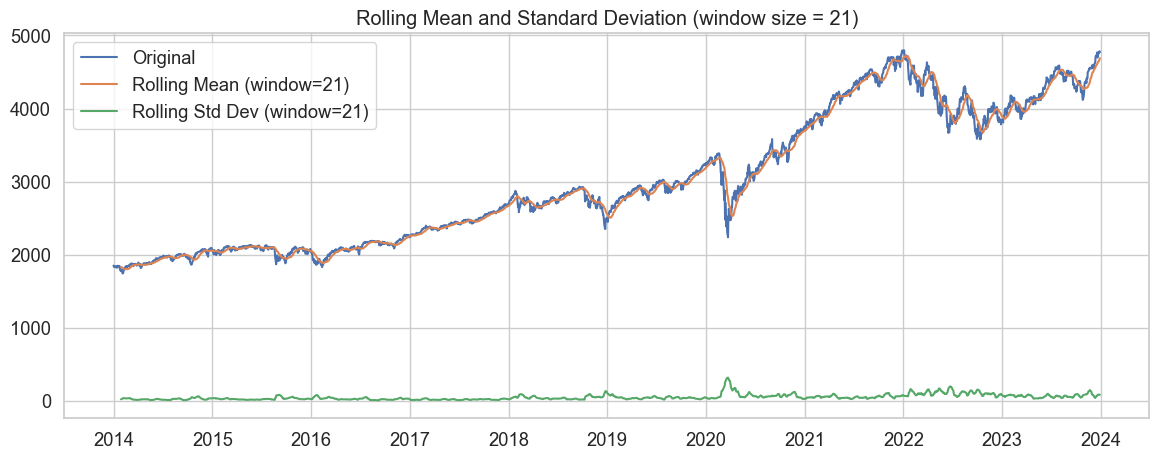

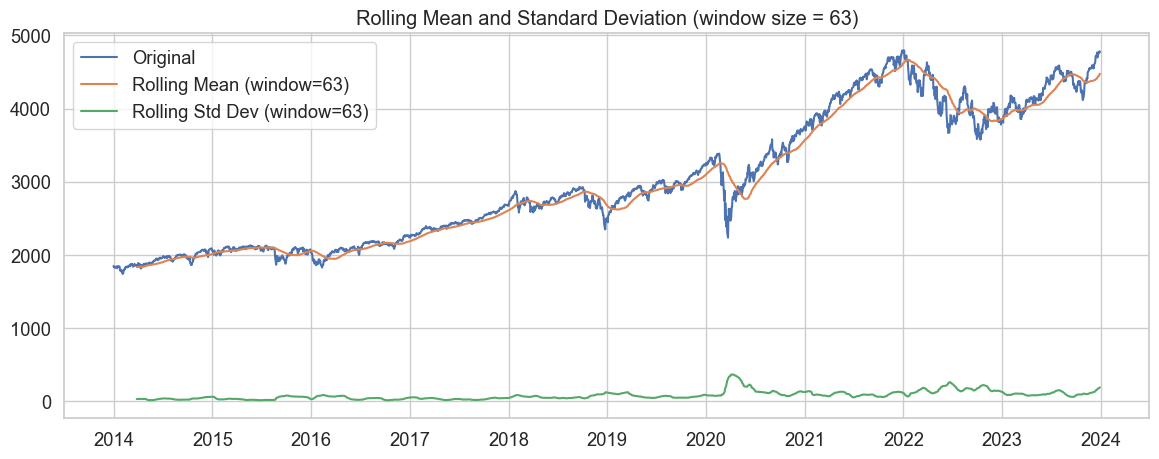

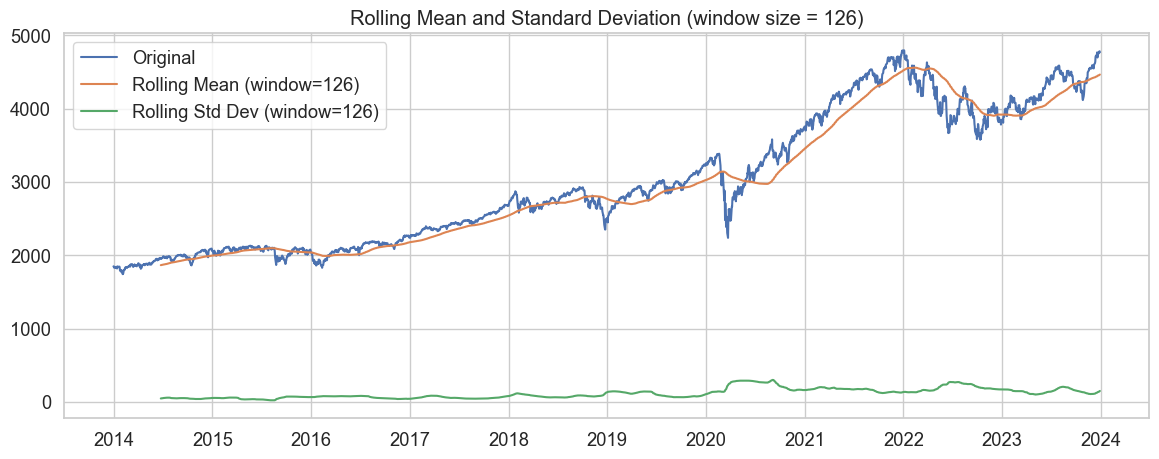

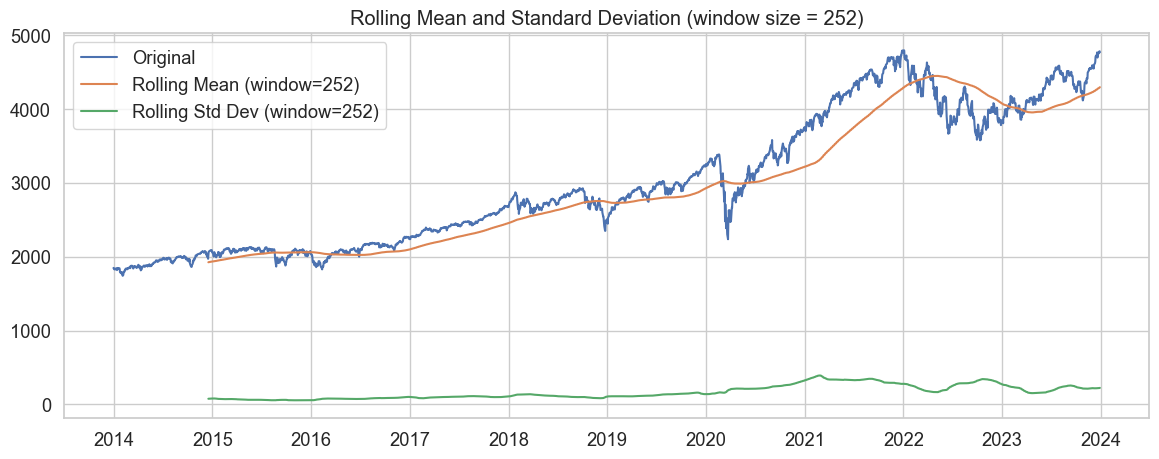

In [18]:
window_sizes = [21, 63, 126, 252]  # A week, a month, a quarter, a yearso  (approximately)
data_close = df_BF  

for window in window_sizes:
    rolling_mean = df_BF.rolling(window=window).mean()
    rolling_std = df_BF.rolling(window=window).std()
    
    plt.figure(figsize=(14, 5))
    plt.plot(df_BF.index, df_BF, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std.index, rolling_std, label=f'Rolling Std Dev (window={window})')
    plt.title(f'Rolling Mean and Standard Deviation (window size = {window})')
    plt.legend()
    plt.show()


- By observing the rolling statistics it is observable that the mean flunctuate over time and the rolling std Dev shows that index present volatility, especially during Covid times.
- Volatility and Flunctuations are more present each time that the window size is decreased.

The analysis of the seasonal decompose indicates that auto-regressive models could be a good start to apply time-series analysis. Due to its auto-correlation, especially at the first lag (parameter indication of AR=1).
However, it is worth to point out that noise/outliers were identified in the residuals. Thus, transformation techniques (i.e.: log, box-cox) could be applied to mitigate the impact of them or apply models that are robust to outliers.  

#### Stationarity 

- Some predictive models assumes that the series is stationary and the following lines of code will check this.

In [19]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df_BF['Close'])

# Output the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

# Display the output
print(adf_output)

Test Statistic                   -0.274940
p-value                           0.928979
#Lags Used                       13.000000
Number of Observations Used    2595.000000
Critical Value (1%)              -3.432872
Critical Value (5%)              -2.862654
Critical Value (10%)             -2.567363
dtype: float64


The ADFuller test indicates that the series is not stationary.
- The p-value is greater than 0.05;
- The statistical value also is higher than the critical values.

Therefore, if the selected model requires stationarity, a transformation technique will have to be applied to meet the assumption. 

Throught the S&P500 index analysis, the series presented a high correlation at a first lag and autoregressive models are suitable for this aspect. However, the index presented other components that could potentially influence the AR (Linear) models performance. 
- Volatility;
- Noise / Outliers;
- Non-stationarity;
- Non-Linear;

In early commits (3th and 4th - experimentation) on Github repository it was observable that the by simpling applying the log returns in the ARIMA (linear models), it does not capture the nuances of the data. The presence of volatility and non-linearity resulted in poor performance. 

So far, the path is leading to the selection of ML models that could capture non-linearity, such as tree-based. And discard linear models, such as ARIMA.
Transformations could mitigate the impact of the components identified and among the techniques the log return is the selected. 

### Log Returns.

Due to the features presented so far, which is not the most approapriate for time series analysis, the transformation approach that is going to be performed is the log return. 

The technique is appropriate and worthy to try due to: 
- Volatility, which is very clear during Covid.
- Is well suitable for financial time series, the approach will use compounded rate of return overtime.
- Stationarity, the transformation could also affect the trend and seasonality.
- It has the potential to reduce the risk of outliers.


In [20]:
# Applying log return in S&P 500 index.
logreturn_data = np.log(df_BF['Close'] / df_BF['Close'].shift(1))

In [21]:
# Because of the log return, the first row of the log will be NaN Value, thus dropping the first row to continue with the analysis.
logreturn_data = logreturn_data.dropna()

In [22]:
# Perform Augmented Dickey-Fuller test to check stationarity.
adf_result = adfuller(logreturn_data)

# Output the results.
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

# Display the output.
print(adf_output)

Test Statistic                -1.477709e+01
p-value                        2.275338e-27
#Lags Used                     1.200000e+01
Number of Observations Used    2.595000e+03
Critical Value (1%)           -3.432872e+00
Critical Value (5%)           -2.862654e+00
Critical Value (10%)          -2.567363e+00
dtype: float64


According to the ADF test the log index return is likely to be stationary.
- The test statistic value is way below the critical values.
- The p-value is way below the 0.05


Financial data has its challenges and having numerous seasonalities in the data makes it challenge to select the right frequence. Thus, the seasonal decompose of the log return will be performed using one month of trading (21). 

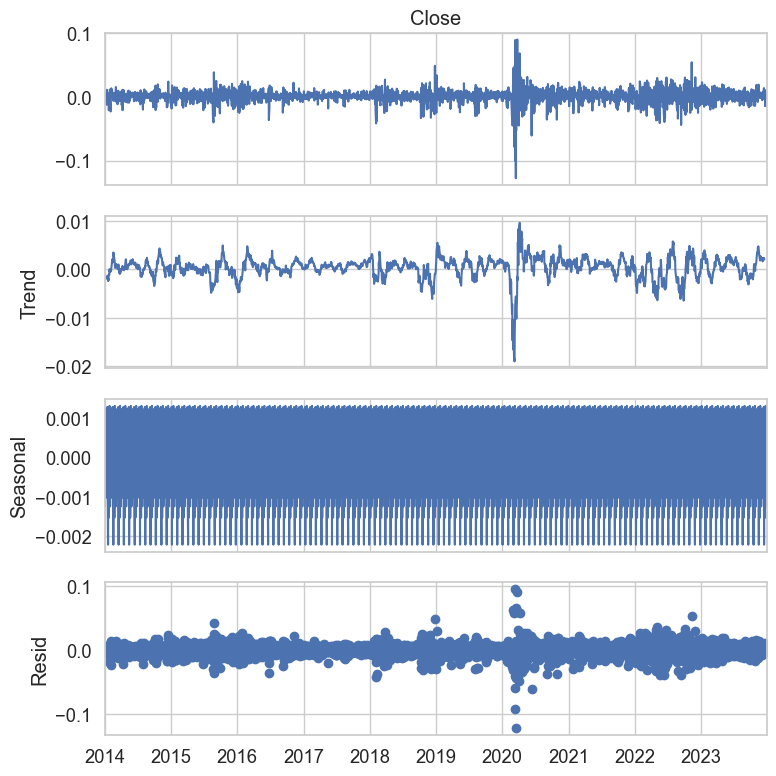

In [23]:
# Different periods were attempted, but the only change was in the shape of the seasonality (more granular as the freq decreased).

## Apply seasonal decompose in the log returns.  
decompositions = seasonal_decompose(logreturn_data, model='additive', period=21)

# Plotting the components of the decomposition.
plt.rcParams.update({'figure.figsize': (8,8)})
decompositions.plot()
plt.show()

The decompoistion plots shows that after the transformation:

- The log returns does not present any trends, however volatility is clearly present and big having spikes during 2020.
- During the cycle of one month of trading it shows seasonality, but it is challeging to define a pattern.
- The residuals shows that most of the values randomly stays around 0, although during 2020 noise and outliers were detected (not capture). Thus, further analysis on the residuals will be performed.

After different attempts on the decompose, the chosen frequency to abalyse the residuals will be monthly (21). 

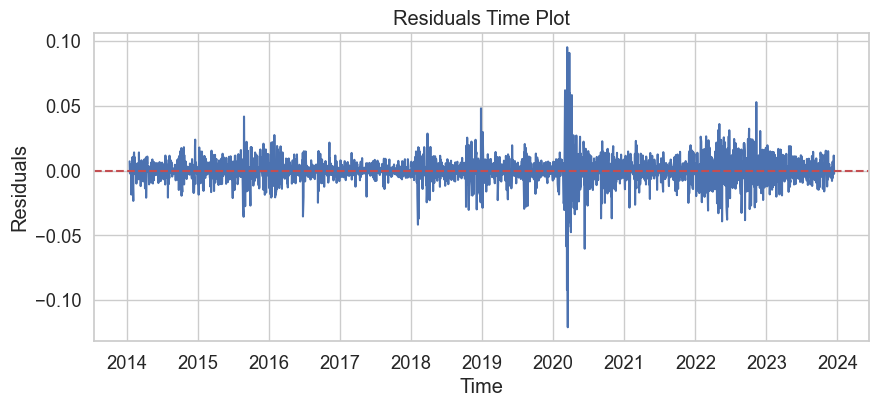

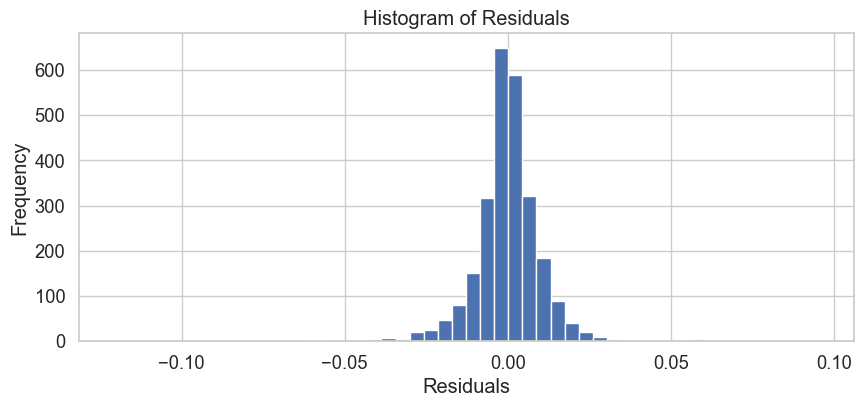

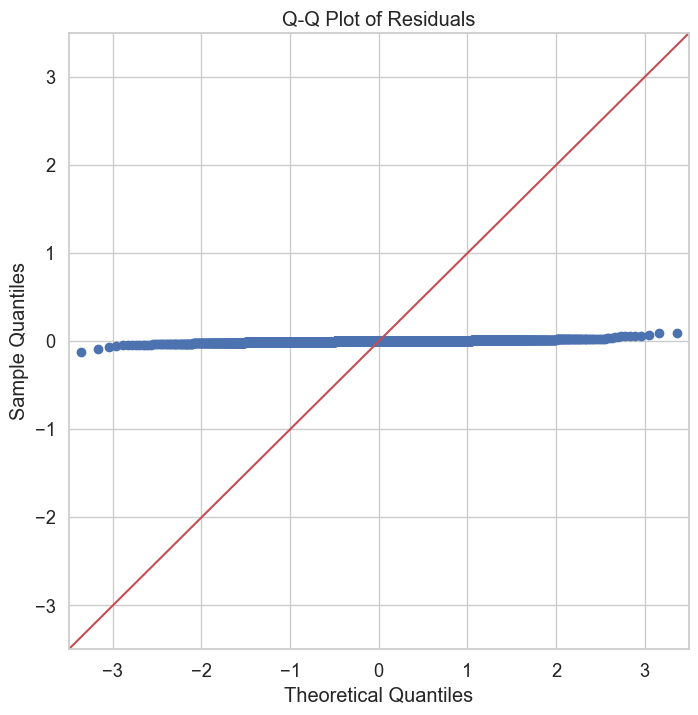

Shapiro-Wilk test statistic: 0.873350977897644, p-value: 1.199091095922746e-41


In [24]:
# Perform seasonal decomposition.
decompositions = seasonal_decompose(logreturn_data, model='additive', period=21)

# Accessing the residual component and dropping nan values. 
residuals = decompositions.resid.dropna()

# Visual Inspection of Residuals: 
## 1. Time plot
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals Time Plot') # Title.
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--') # Line settings.
plt.show()

## 2. Histogram of residuals.
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50) # Setting bins for optimal visualization.
plt.title('Histogram of Residuals') # Title.
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## 3. Q-Q plot of residuals.
sm.qqplot(residuals, line ='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test for normality of the residuals.
shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}")

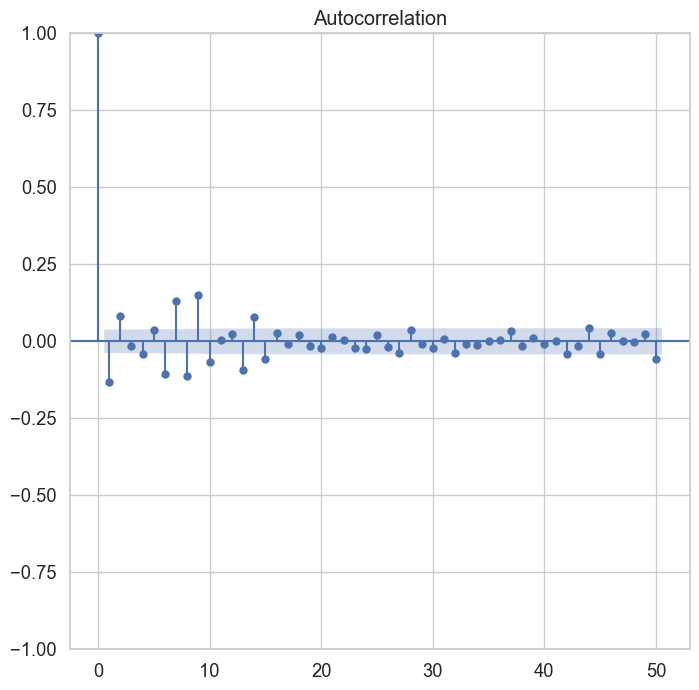

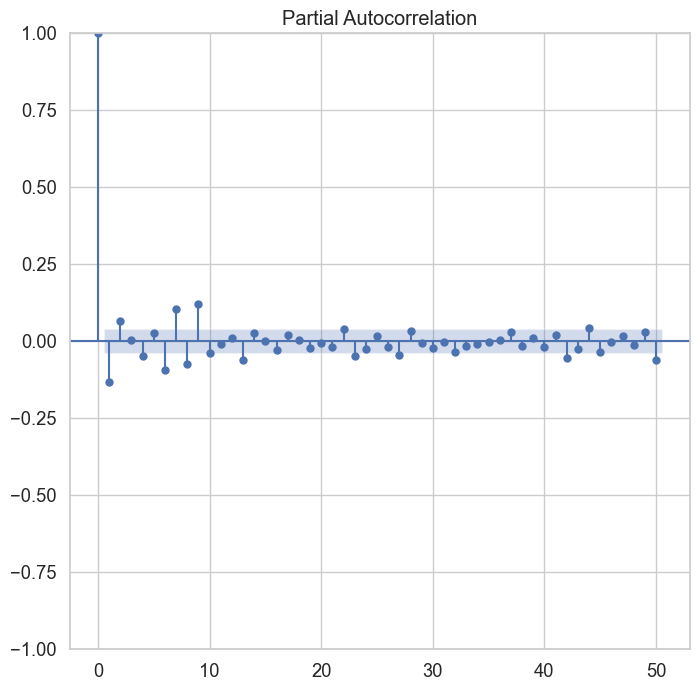

In [25]:
# ACF and PACF to check autocorrelation and initial parameters for the auto regressive models.

# Plot ACF
plot_acf(logreturn_data, lags=50)  # You can adjust the number of lags as needed
plt.show()

# Plot PACF
plot_pacf(logreturn_data, lags=50)  # You can adjust the number of lags as needed
plt.show()

The analysis up to this point were made on the raw data (S&P 500 index) and the log returns. 

- By analysing the residuals it indicates that the residuals are not normally distributed and with the aid of the Q-Q plot, the assumption to be followed is the strong presence of non-linearity in the series.
- The ACF and PACF shows little correlation, after the first lag, most of the values stays under the confidence of interval. (Weak for auto-regressive)
- Volatility and non-linearity still present.

<b> Therefore the focus of the experimentation will turn direction to non-linear ML, such as tree-based, and Neural Networks due to the observations made up to this stage. In addition, the log returns will be the chosen variabe, instead of the index, due to its benefits observed after the transformation. </b>

- The first stage of the experimentation will be using just the index log returns along with hyperparameter-tunning (GridSearchCV). These models will be considered the benchmark for further improvements.
- Second step will evaluate models including rolling standard deviation as a feature. 
- Third stage will include model/feature that could help the model to address volatility (especially clustered around 2020). The GARCH will be performed and a new component will be include in the series. Later, same predictive technologies will be applied to compare the performance between them. 

<b> - LAGS? </B>

In [26]:
from sklearn.model_selection import train_test_split
df_log_BM = logreturn_data.copy().to_frame() # Leaving a copy of the original series.

# Setting the train and test only with the log_returns as feature. 
X = df_log_BM[['Close']]  # Using log returns directly as features
y = df_log_BM['Close'].shift(-1)  # Predicting the next day's log return
y.dropna(inplace=True)
X = X.iloc[:-1]  # Align X to the y we just shifted

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

<center><b>Random Forest Regressor.</b></center>

- Could handle non-linear relationations;
- Known to be appropriate against outliers/noise;

- The first models will be performed using Rolling Std. Dev. of one week. 

Root Mean Squared Error: 0.010842185425476046
Mean Absolute Error: 0.008405730830863963
Mean Absolute Percentage Error: 51318442611538.92%


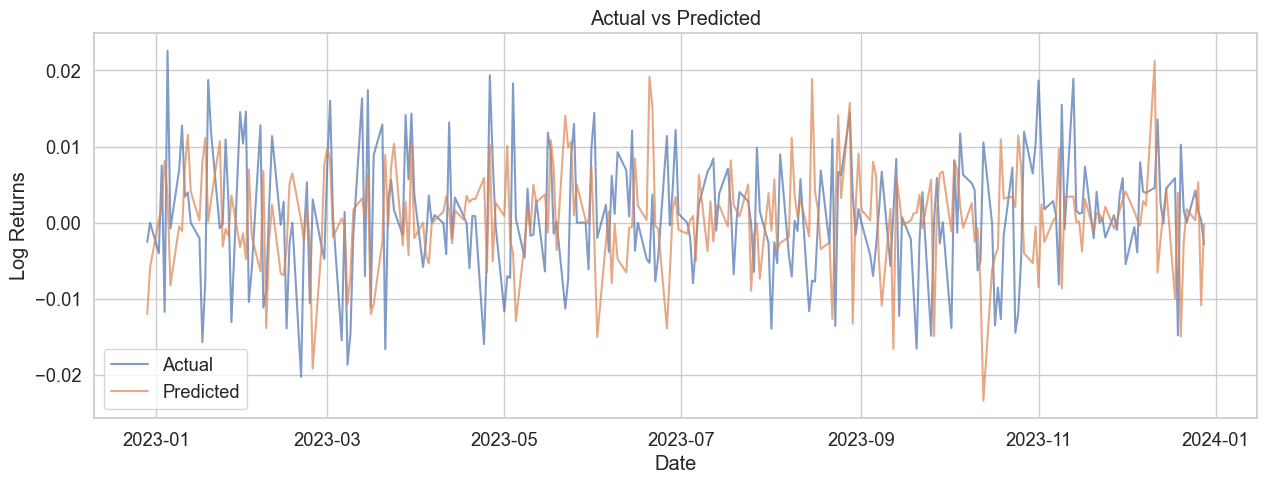

In [27]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [28]:
# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")

Best parameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 300}
Best RMSE from Grid Search: 0.012467788387566747


Root Mean Squared Error: 0.008170861253676281
Mean Absolute Error: 0.006303028734159385
Mean Absolute Percentage Error: 10315537199339.34%


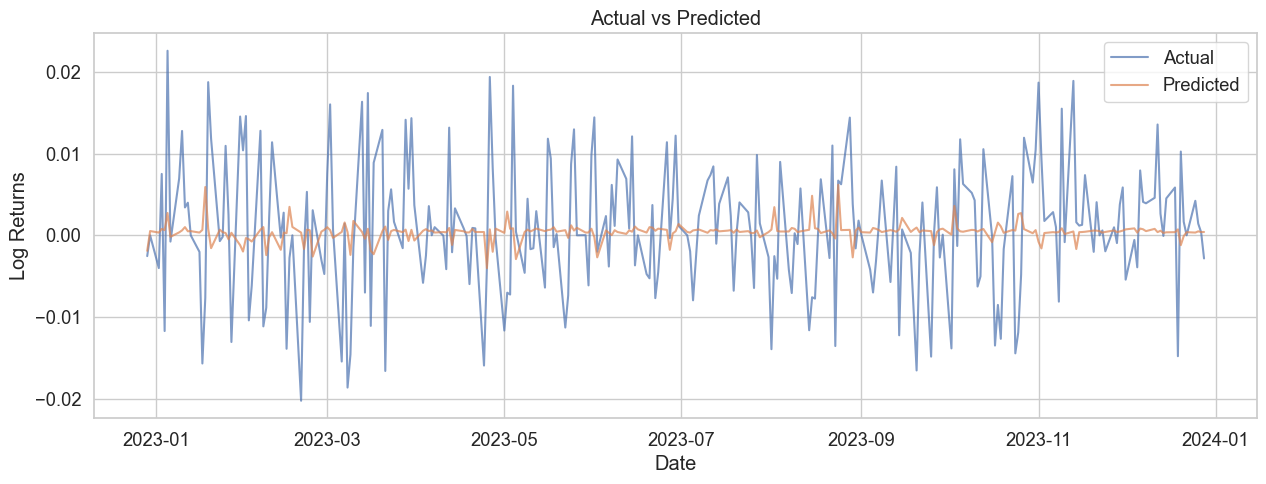

In [29]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=300, 
                                max_depth=10, 
                                min_samples_split=6, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the  plot.

<center><b>Support Vector Regressor.</b></center> 

Root Mean Squared Error: 0.008027486172796871
Mean Absolute Error: 0.006194923024439998
Mean Absolute Percentage Error: 11439026928212.52%


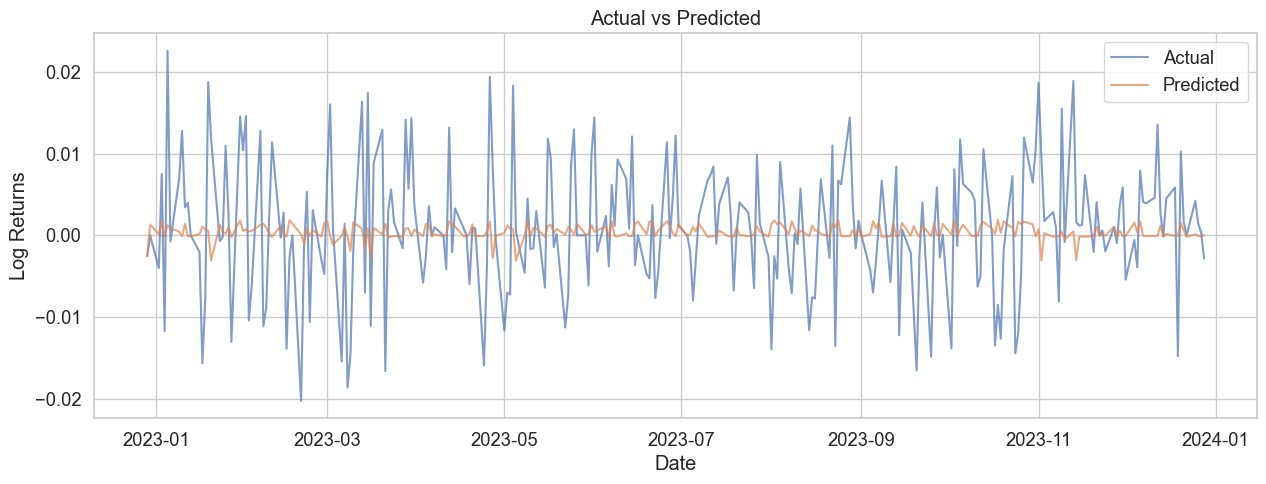

In [30]:
# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=500, epsilon=0.0001)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [31]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type. It takes too much time to run if other types are included ( 'poly', 'sigmoid' or 'linear').
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [ 0.01, 1, 10]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

Best SVR parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Best RMSE from SVR Grid Search: 0.011945359305845522


Root Mean Squared Error: 0.008140203518812481
Mean Absolute Error: 0.006295664515922225
Mean Absolute Percentage Error: 5112646740108.47%


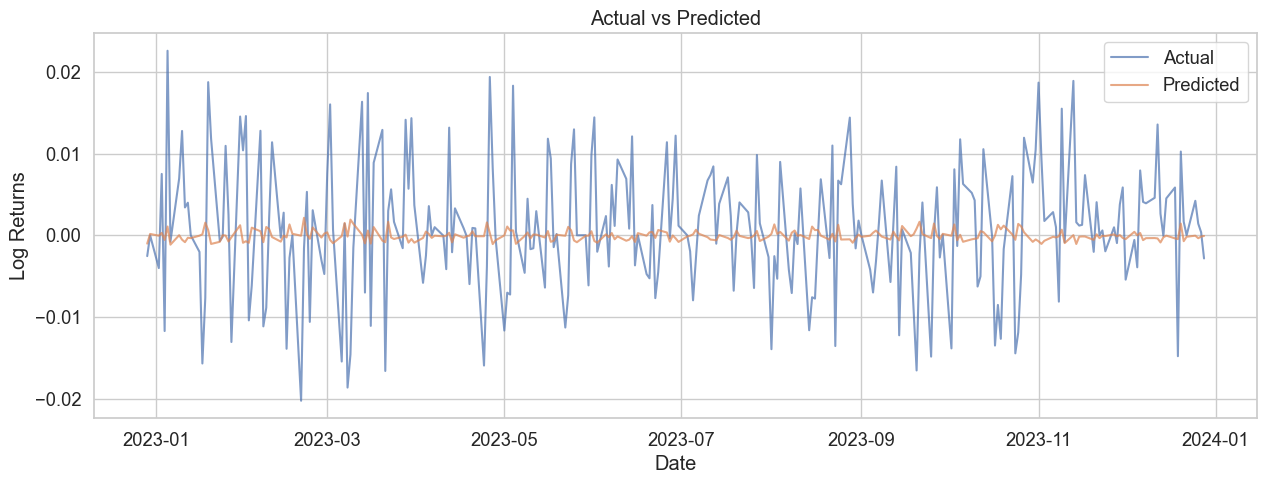

In [32]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=100, epsilon=0.01, gamma='auto', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Gradient Boosting Regressor.</b></center> 

Root Mean Squared Error: 0.008118567760402326
Mean Absolute Error: 0.006255938975931744
Mean Absolute Percentage Error: 10733722052524.81%


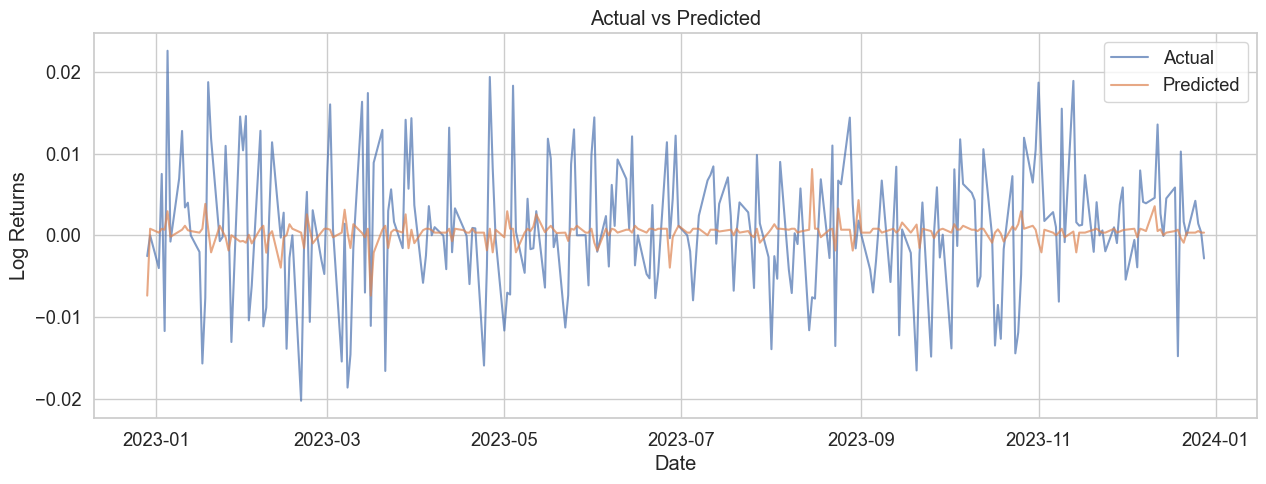

In [33]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [34]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node.
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

Best GBM parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE from GBM Grid Search: 0.012059703884424806


Root Mean Squared Error: 0.008066984962845334
Mean Absolute Error: 0.006196662009758688
Mean Absolute Percentage Error: 6269324225720.62%


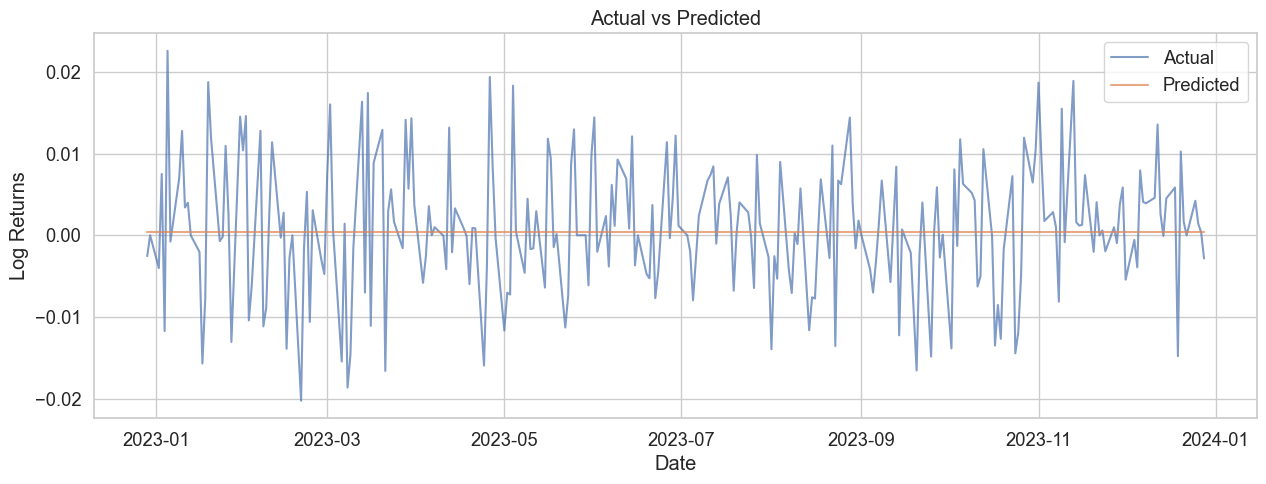

In [35]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

- The previous models were applied using the S&P500 Index Log Returns and were going to be used as benchmark for further improvements.

## Feature Engineering (Rolling Standard Deviation).



<b><center> DO I APPLY BOTH OF THE FEATURE ENGINEERING AND LOSE THE FIRST ROWS ONLY ONCE?????? LAG AND ROLL.STD.DEV.

- After applying the log returns, the high volatility is still present and among the statistical featuras that can be extract, the rolling standard deviation is the most appropriate candidate for this series.
- It will be performed using 2 different frequency, weekly and monthly. Thus, comparing the performance to use the best option.

The process to select the best frequency for the statistical feature will be performed by creating 3 dataframes for each period. 

In [36]:
logreturn_std = logreturn_data.copy().to_frame() # Leaving a copy of the original series.

# Copy of the dataframe to shift for a day of trading (1)
log_5 = logreturn_std.copy()

# Copy of the dataframe to shift for one month of trading (21).
log_21 = logreturn_std.copy()

# Calculates rolling standard deviation (historical volatility using windows of a week, two weeks and a month).
log_5['rolling_std_5'] = log_5['Close'].rolling(window=5).std()
log_21['rolling_std_21'] = log_21['Close'].rolling(window=21).std()

# Calculates de lag of one week and one month.
log_5['lag_5']  = log_5['Close'].shift(5) 
log_21['lag_21']  = log_21['Close'].shift(21)

# Calculate the 5-day moving average
log_5['MA_5'] = log_5['Close'].rolling(window=5).mean()
log_21['MA_21'] = log_21['Close'].rolling(window=5).mean()

- The calculation of the feature automatically generates NaN values, so following codes will check and drop the values.
- No imputation is considered, the data has noise already and by doing it could introduce more. 

In [37]:
# Check the results of the previous code.
missing_values_5 = log_5.isnull().sum()
missing_values_21 = log_21.isnull().sum()

# Prints the results.
(missing_values_5, missing_values_21)

(Close            0
 rolling_std_5    4
 lag_5            5
 MA_5             4
 dtype: int64,
 Close              0
 rolling_std_21    20
 lag_21            21
 MA_21              4
 dtype: int64)

In [38]:
# Drop the rows with NaN values in each data frame that were introduced by shifting.
log_5.dropna(inplace=True)
log_21.dropna(inplace=True)

In [39]:
# Check the results of the previous code.
missing_values_5 = log_5.isnull().sum()
missing_values_21 = log_21.isnull().sum()

# Prints the results.
(missing_values_5, missing_values_21)

(Close            0
 rolling_std_5    0
 lag_5            0
 MA_5             0
 dtype: int64,
 Close             0
 rolling_std_21    0
 lag_21            0
 MA_21             0
 dtype: int64)

- The number of missing values were exactly the ones expected and them dropped.

Because it is going to be used as a feature, a correlation anlysins will be performed, so as EDA steps.

             Close  rolling_std_5        lag_5         MA_5
count  2603.000000    2603.000000  2603.000000  2603.000000
mean      0.000366       0.008523     0.000363     0.000367
std       0.011021       0.007301     0.011023     0.004551
min      -0.127652       0.000530    -0.127652    -0.039609
25%      -0.003547       0.004213    -0.003553    -0.001455
50%       0.000311       0.006773     0.000299     0.000740
75%       0.005255       0.010520     0.005266     0.002739
max       0.089683       0.095935     0.089683     0.032079
                  Close  rolling_std_5     lag_5      MA_5
Close          1.000000      -0.032817  0.034966  0.430242
rolling_std_5 -0.032817       1.000000 -0.168992 -0.268664
lag_5          0.034966      -0.168992  1.000000 -0.037191
MA_5           0.430242      -0.268664 -0.037191  1.000000


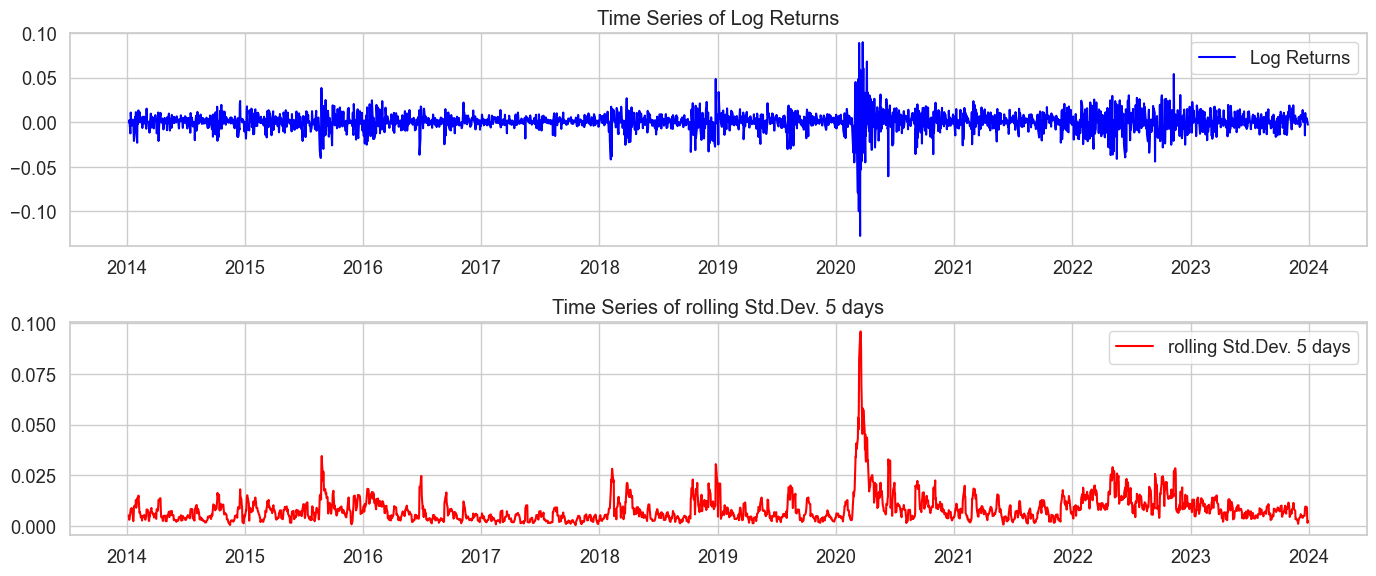

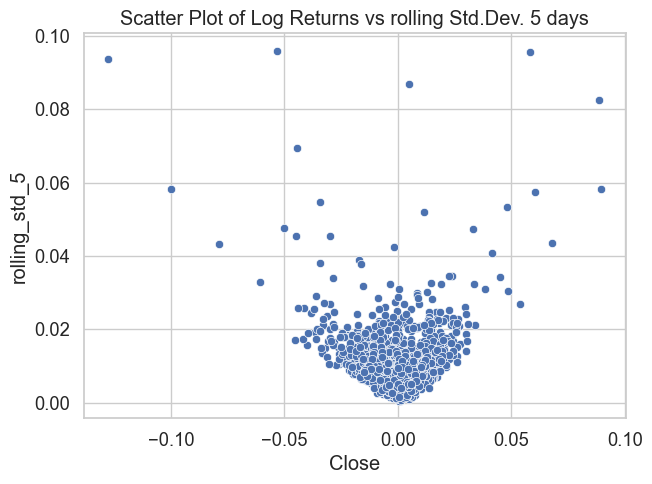

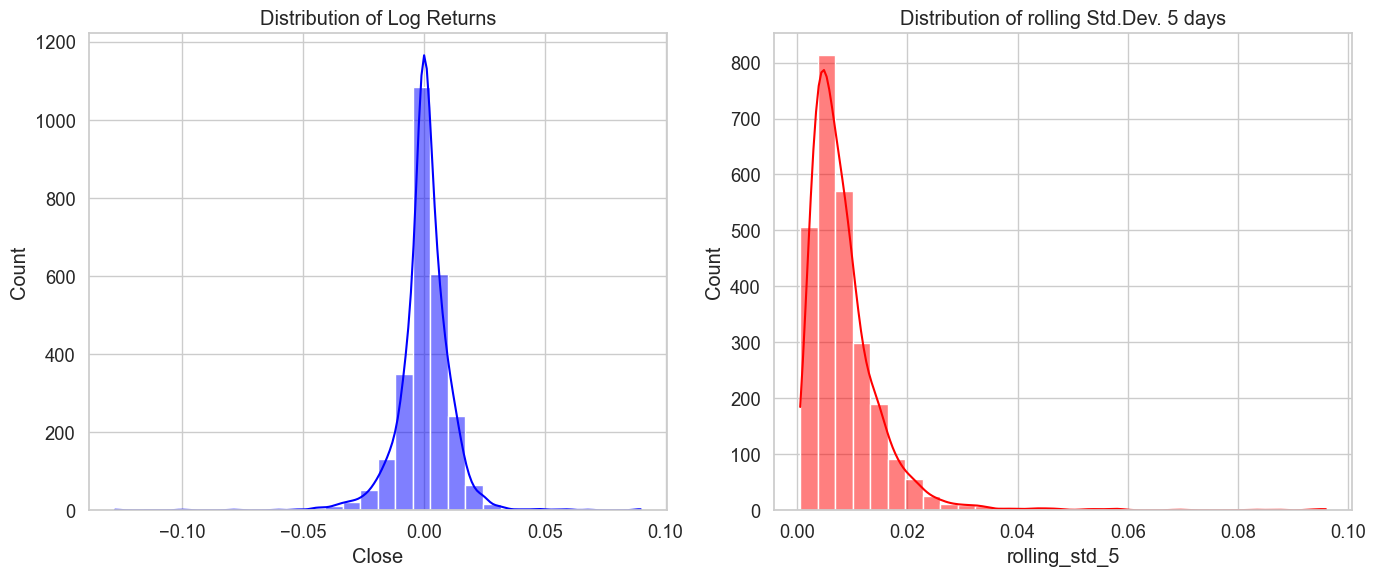

In [40]:
# Summary Statistics.
print(log_5.describe())

# Correlation Analysis.
print(log_5.corr())

# Plotting EDA to check the relationship between the two, so any visiable trend will be indentified.
## Time Series Plot for log returns.
plt.figure(figsize=(14, 6)) 
plt.subplot(2, 1, 1)
plt.plot(log_5['Close'], label='Log Returns', color='blue') # Adds label and sets color.
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()
## Time Series Plot for rolling Std.Dev. one week.
plt.subplot(2, 1, 2)
plt.plot(log_5['rolling_std_5'], label='rolling Std.Dev. 5 days', color='red') # Adds label and sets color.
plt.title('Time Series of rolling Std.Dev. 5 days') # Adds title.
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot to visually check the corelation between the two features. 
plt.figure(figsize=(7, 5))
sns.scatterplot(data=log_5, x='Close', y='rolling_std_5') # Sets the two variable for the plot.
plt.title('Scatter Plot of Log Returns vs rolling Std.Dev. 5 days') # Adds title.
plt.show() # Generate the TS plots

# Histograms will check the distributions, but mainly the frequency of volatility, which depending on how it is skewed will represent numerous peaks 
# of volatily.
## Distribution of 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(log_5['Close'], bins=30, kde=True, color='blue') # Sets bin and color for optmal visualization.
plt.title('Distribution of Log Returns') # Adds title.

plt.subplot(1, 2, 2)
sns.histplot(log_5['rolling_std_5'], bins=30, kde=True, color='red') # Sets bin and color for optmal visualization.
plt.title('Distribution of rolling Std.Dev. 5 days') # Adds title.
plt.tight_layout() # Adjusts layout.
plt.show() # Generates the Hist. plots.

             Close  rolling_std_21       lag_21        MA_21
count  2587.000000     2587.000000  2587.000000  2587.000000
mean      0.000382        0.009141     0.000350     0.000378
std       0.011037        0.006292     0.011044     0.004557
min      -0.127652        0.002185    -0.127652    -0.039609
25%      -0.003532        0.005318    -0.003565    -0.001452
50%       0.000312        0.007545     0.000288     0.000746
75%       0.005274        0.011398     0.005255     0.002753
max       0.089683        0.061454     0.089683     0.032079
                   Close  rolling_std_21    lag_21     MA_21
Close           1.000000        0.008105  0.012738  0.429802
rolling_std_21  0.008105        1.000000 -0.129540 -0.043576
lag_21          0.012738       -0.129540  1.000000 -0.011007
MA_21           0.429802       -0.043576 -0.011007  1.000000


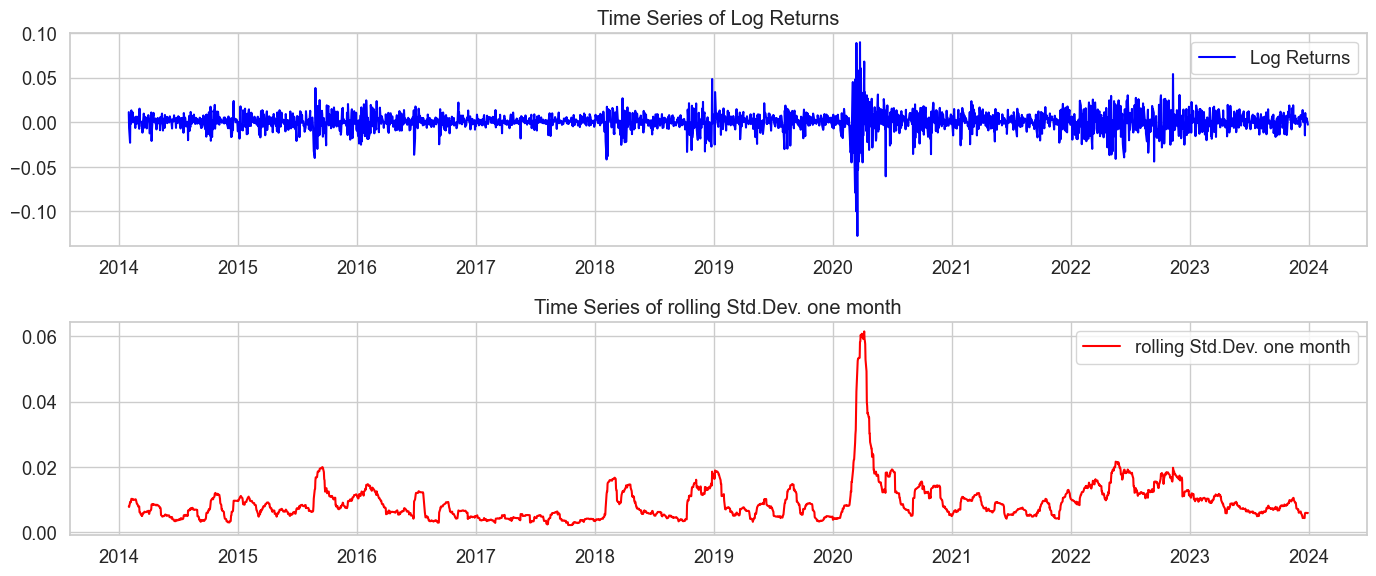

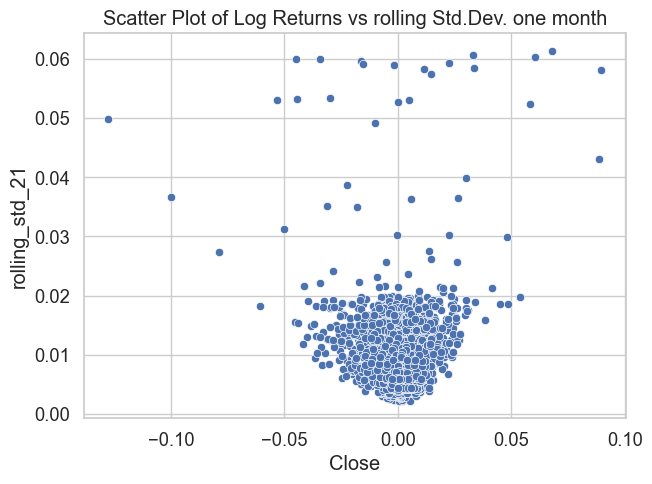

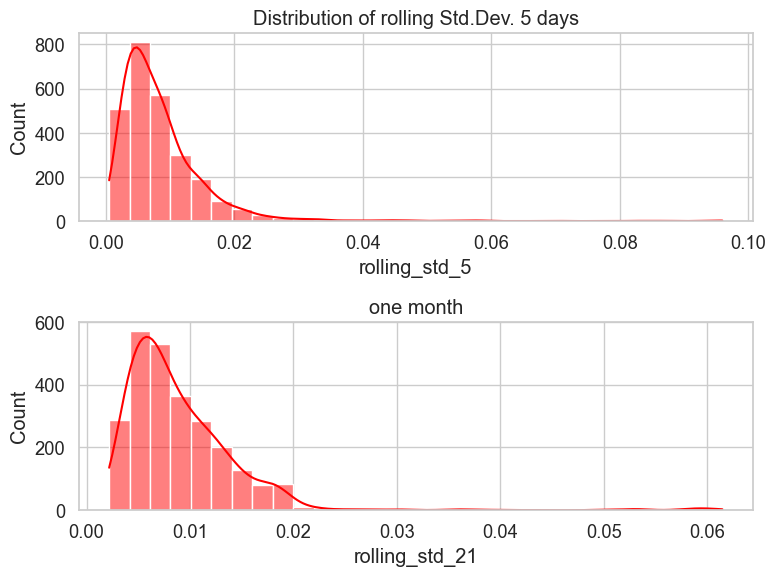

In [41]:
# Summary Statistics.
print(log_21.describe())

# Correlation Analysis.
print(log_21.corr())

# Plotting EDA to check the relationship between the two, so any visiable trend will be indentified.
## Time Series Plot for log returns.
plt.figure(figsize=(14, 6)) 
plt.subplot(2, 1, 1)
plt.plot(log_21['Close'], label='Log Returns', color='blue') # Adds label and sets color.
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()
## Time Series Plot for rolling Std.Dev. one month.
plt.subplot(2, 1, 2)
plt.plot(log_21['rolling_std_21'], label='rolling Std.Dev. one month', color='red') # Adds label and sets color.
plt.title('Time Series of rolling Std.Dev. one month') # Adds title.
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot to visually check the corelation between the two features. 
plt.figure(figsize=(7, 5))
sns.scatterplot(data=log_21, x='Close', y='rolling_std_21') # Sets the two variable for the plot.
plt.title('Scatter Plot of Log Returns vs rolling Std.Dev. one month') # Adds title.
plt.show() # Generate the TS plots

# Histograms will check the distributions, but mainly the frequency of volatility, which depending on how it is skewed will represent numerous peaks 
# of volatily.
plt.figure(figsize=(8, 6))  # Adjust the width to accommodate three plots side by side.
plt.subplot(2, 1, 1)
sns.histplot(log_5['rolling_std_5'], bins=30, kde=True, color='red') # Sets bin and color for optmal visualization.
plt.title('Distribution of rolling Std.Dev. 5 days') # Adds title.

plt.subplot(2, 1, 2)
sns.histplot(log_21['rolling_std_21'], bins=30, kde=True, color='red') # Sets bin and color for optmal visualization.
plt.title('one month') # Adds title.
plt.tight_layout() # Adjusts layout.
plt.show() # Generates the Hist. plots.

According to the features extracted from the previous codes (all the three frequencies).

The statistical properties:
- Indicates the higher the period, higher the mean. So, capturing long-periods of valatility. 

The Correlation score:
- The scores for all the periods shows very weaky correlation  between the variables.
  
The time-series plots:
- Shows how volatile the log returns are overtime, pointing a huge peak during 2020.
- The lower the frequency the more sensitive to volatility is presented. The one month period it has a slightly smoother line, comparing to the one week.

The Scatter-plots:
- The plots for all periods shows that the Index log returns and the rolling Std.Dev does not have strong linear correlation, presenting random patterns and clustered around zero.

The Distributions over time:
- The plots shows that low volatility is much more present than the high (right-skewed).

<b> In order to check the performance of ML models, the comparion will be performed between the frequencies under the same conditions. </b>

## ML models - One week frequency.

<center><b>Random Forest Regressor.</b></center> 

In [42]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions)
X = log_5['rolling_std_5']

# Target variable - Predicting the log return.
y = log_5['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X to be a 2D array - required by the models.
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

Root Mean Squared Error: 0.010387059753454457
Mean Absolute Error: 0.007775606038464469
Mean Absolute Percentage Error: 70835958585461.16%


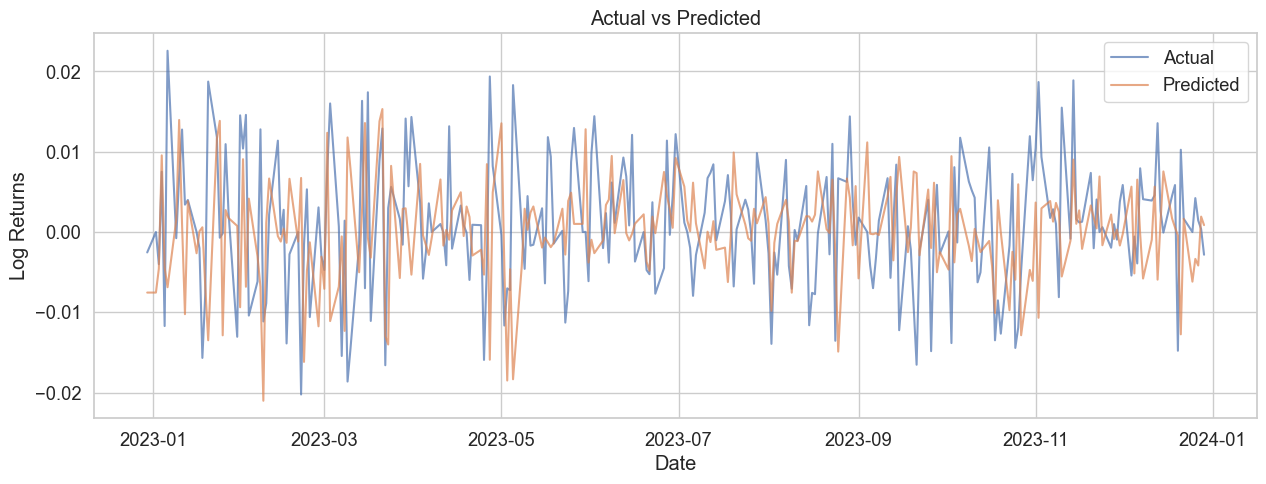

In [43]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [44]:
# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")

Best parameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 300}
Best RMSE from Grid Search: 0.012973614586196095


Root Mean Squared Error: 0.008086230389301452
Mean Absolute Error: 0.006200659522991117
Mean Absolute Percentage Error: 6396495747855.64%


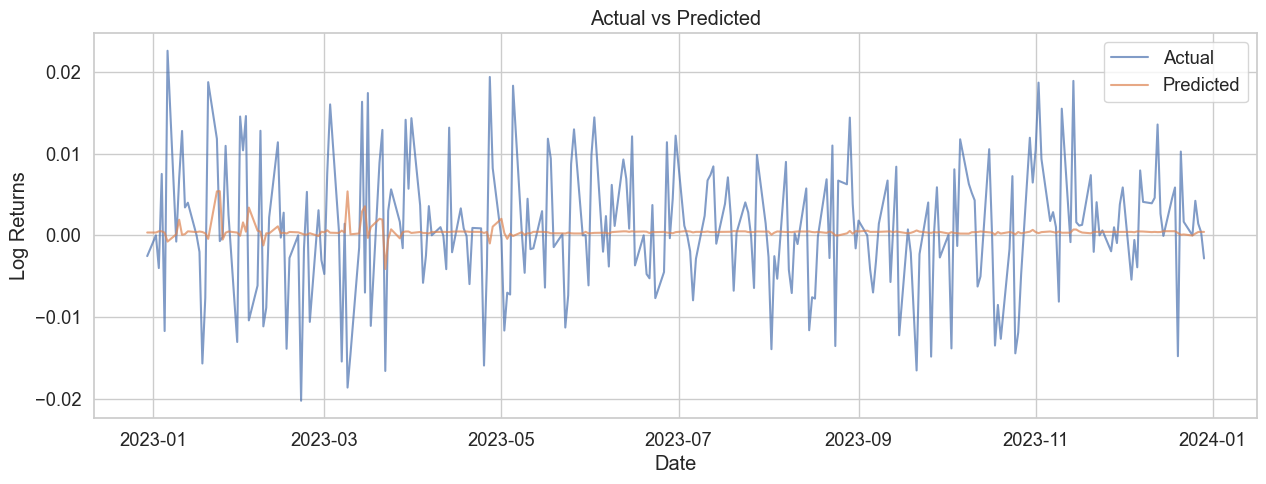

In [45]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=2, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the  plot.

<center><b>Support Vector Regressor.</b></center> 

Root Mean Squared Error: 0.007986844258569041
Mean Absolute Error: 0.00615678651938287
Mean Absolute Percentage Error: 6990963257718.13%


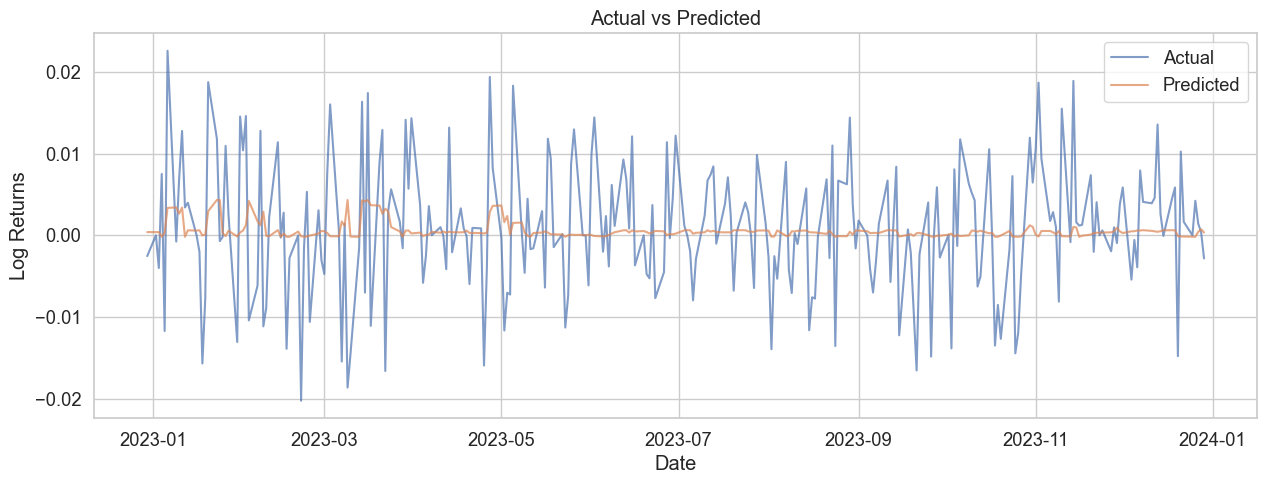

In [46]:
# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=500, epsilon=0.0001)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [47]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type. It takes too much time to run if other types are included ( 'poly', 'sigmoid' or 'linear').
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [ 0.01, 1, 10]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

Best SVR parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Best RMSE from SVR Grid Search: 0.011971502049219837


Root Mean Squared Error: 0.008072403773738567
Mean Absolute Error: 0.0061976317545773445
Mean Absolute Percentage Error: 3073403621707.19%


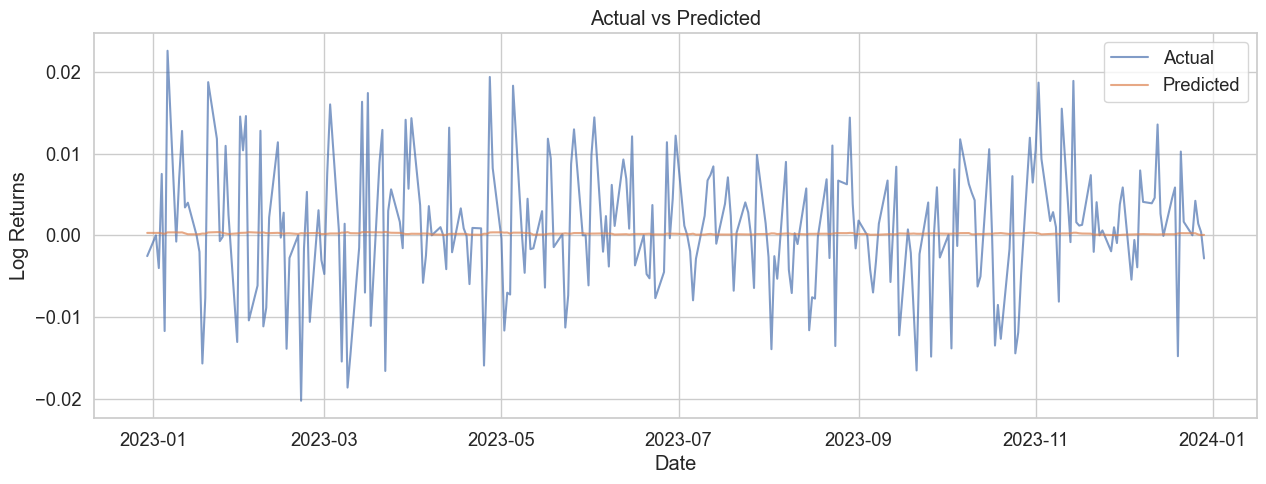

In [48]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=0.1, epsilon=0.01, gamma='auto', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Gradient Boosting Regressor.</b></center> 


Root Mean Squared Error: 0.00811460013169574
Mean Absolute Error: 0.006223544202649209
Mean Absolute Percentage Error: 9370163359104.64%


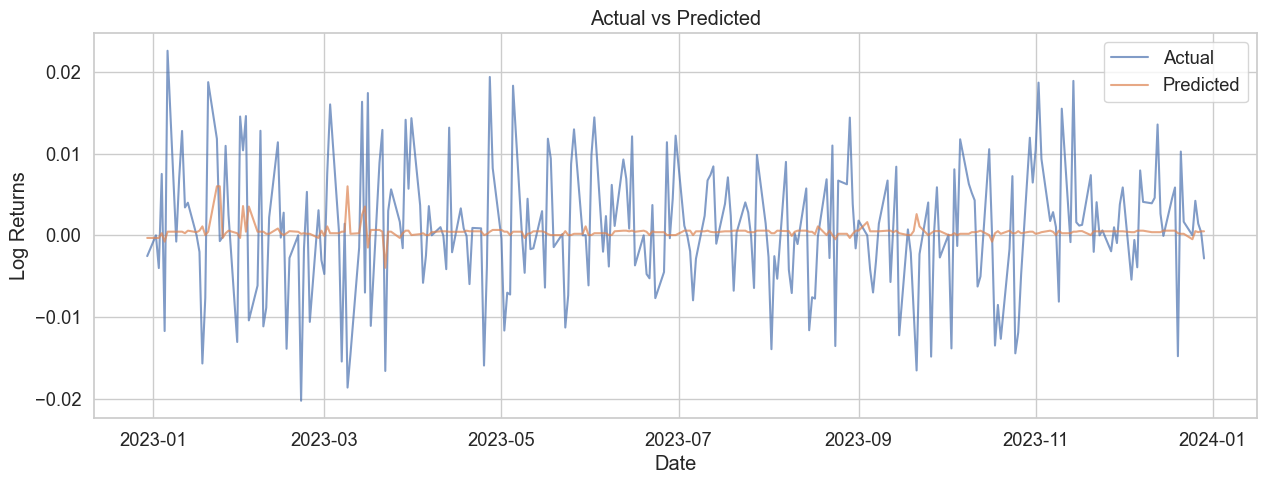

In [49]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [50]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node.
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

Best GBM parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE from GBM Grid Search: 0.012048773069270163


Root Mean Squared Error: 0.00806774256460407
Mean Absolute Error: 0.00619671212892926
Mean Absolute Percentage Error: 6043607547808.03%


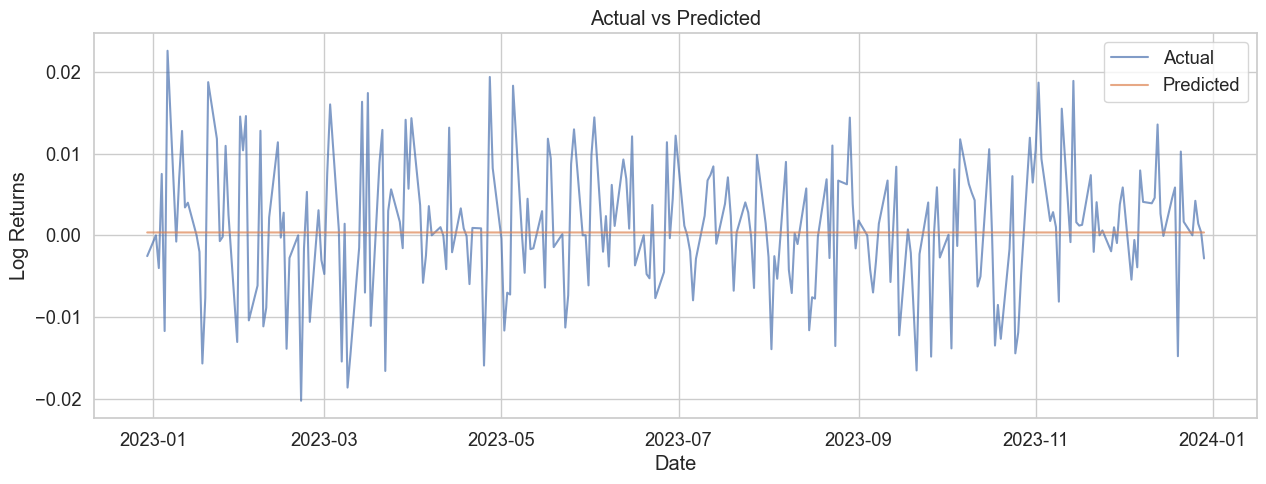

In [51]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

## ML models - One month frequency.

<center><b>Random Forest Regressor.</b></center>

In [52]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions)
X = log_21['rolling_std_21']

# Target variable - Predicting the log return.
y = log_21['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X to be a 2D array - required by the models.
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

Root Mean Squared Error: 0.010616127115092851
Mean Absolute Error: 0.008265425385744535
Mean Absolute Percentage Error: 87326580543576.36%


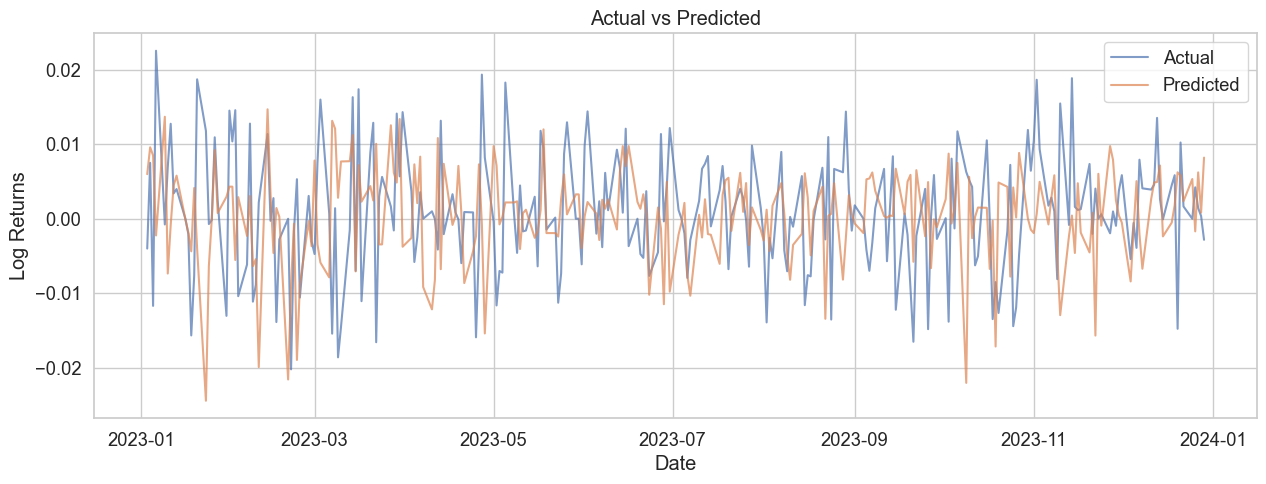

In [53]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [54]:
# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")

Best parameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 500}
Best RMSE from Grid Search: 0.01242063509128115


Root Mean Squared Error: 0.008085650453873659
Mean Absolute Error: 0.006230453306450109
Mean Absolute Percentage Error: 6410424659748.98%


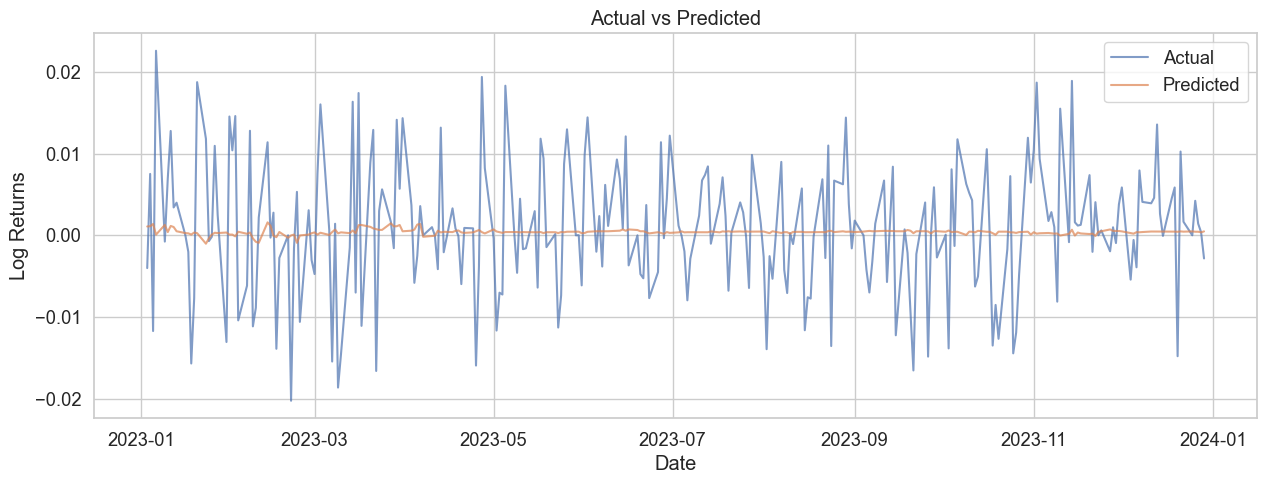

In [55]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=200, 
                                max_depth=10, 
                                min_samples_split=6, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Support Vector Regressor.</b></center> 

Root Mean Squared Error: 0.017626095517683852
Mean Absolute Error: 0.015782199159048736
Mean Absolute Percentage Error: 232023908422496.44%


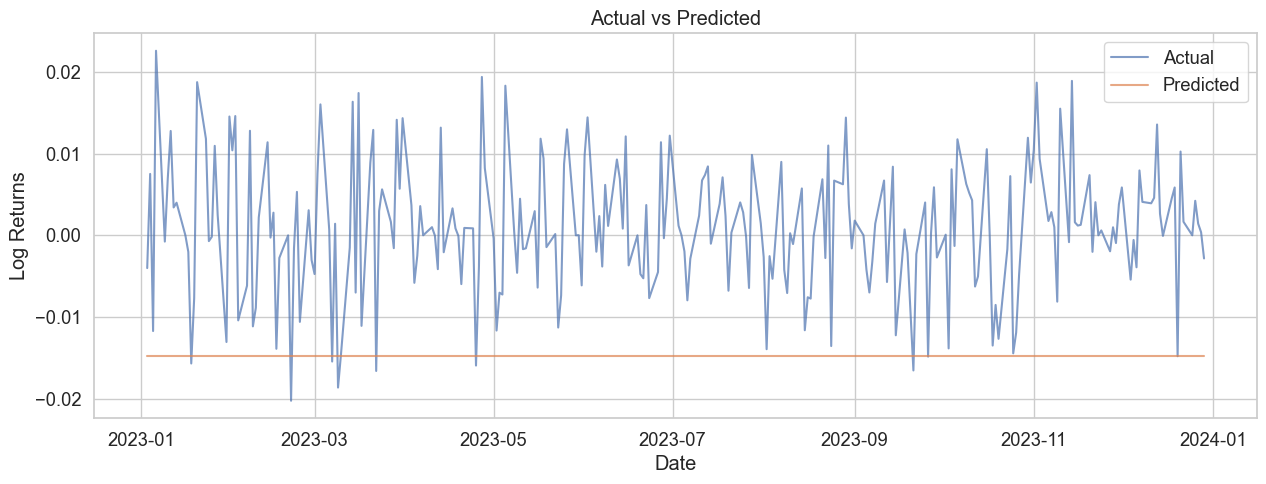

In [56]:
# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [57]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type. It takes too much time to run if other types are included ( 'poly', 'sigmoid' or 'linear').
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [ 0.01, 1, 10]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

Best SVR parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Best RMSE from SVR Grid Search: 0.011977136105199074


Root Mean Squared Error: 0.00808222360486984
Mean Absolute Error: 0.0062294835885387005
Mean Absolute Percentage Error: 9204109909936.28%


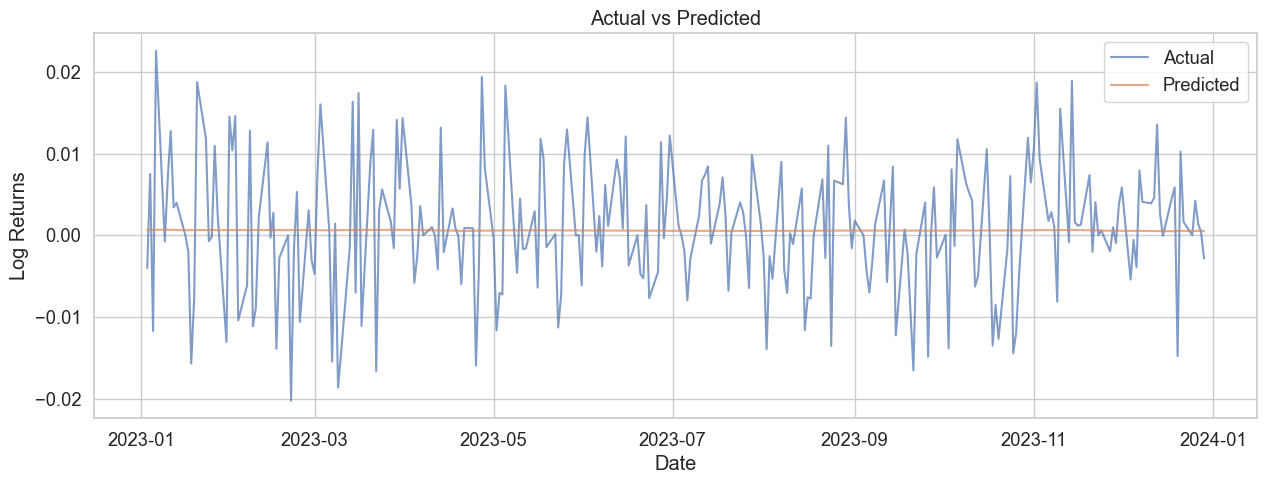

In [58]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=0.1, epsilon=0.01, gamma='auto', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Gradient Boosting Regressor.</b></center> 

Root Mean Squared Error: 0.00811949673181014
Mean Absolute Error: 0.006246957463979849
Mean Absolute Percentage Error: 5184160241508.28%


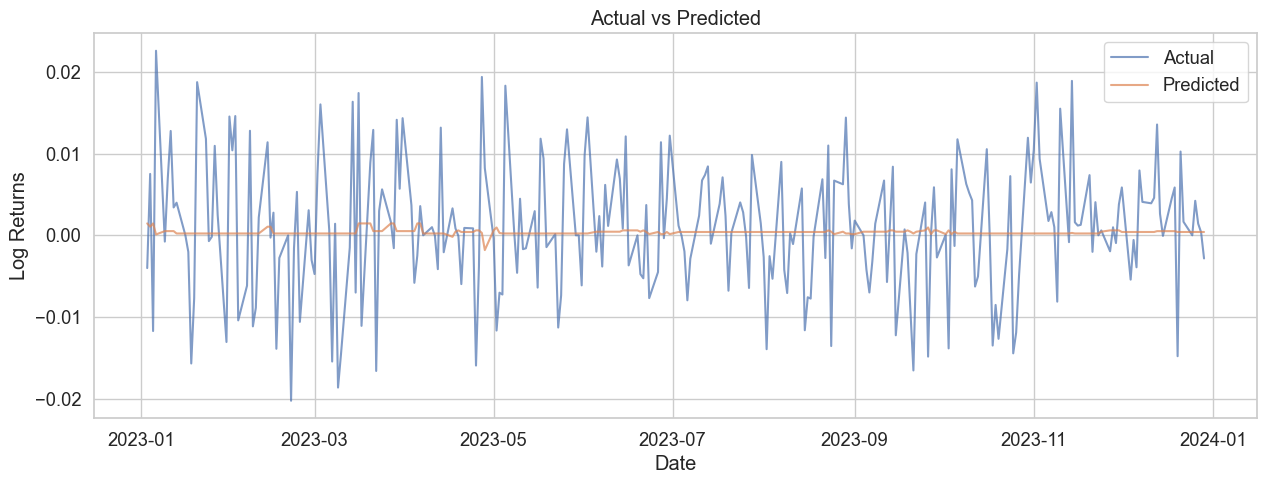

In [59]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [60]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

Best GBM parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE from GBM Grid Search: 0.012035311382220042


Root Mean Squared Error: 0.00809991425355047
Mean Absolute Error: 0.0062327840623814905
Mean Absolute Percentage Error: 4710994215513.53%


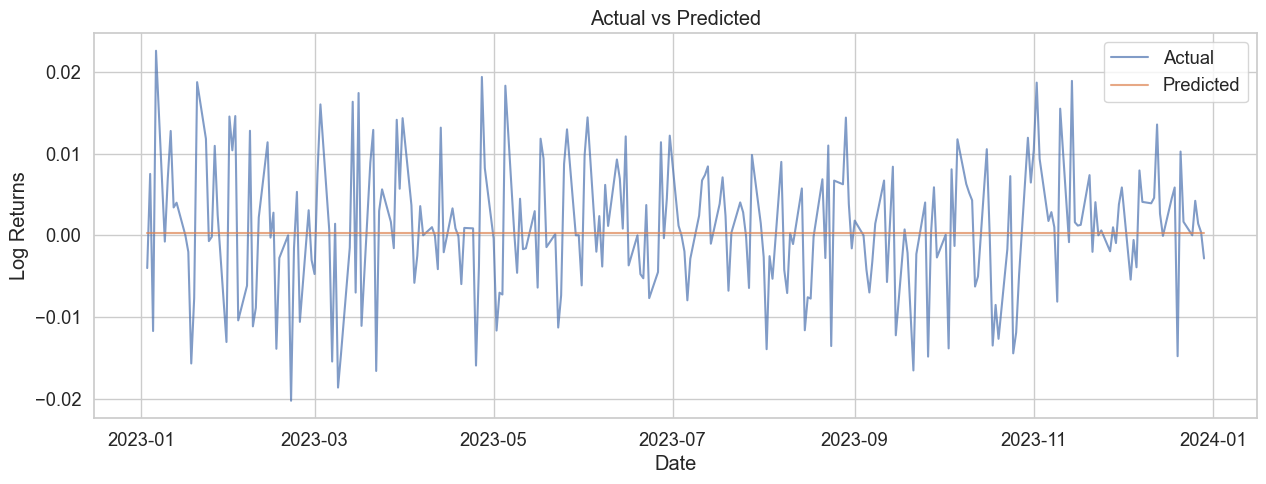

In [61]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

The GARCH model will attempt to help models in optimization terms (tackle volatility), it also requires parameters p and q to run. However, due to the number of possibilities, a Grid Search will be perfomerd to find the optimal value based on the AIC and BIC criteria. 

# Models Including Lags - Same frequency as the rolling standard deviation.

<b> Applying models including a new feature that will help with the temporal component, the lag feature, which will be performed using frequency of one week and one month.

First, the 5 days - One week of Lag.

In [62]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions)
X = log_5[['rolling_std_5', 'lag_5']]

# Target variable - Predicting the log return.
y = log_5['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X to be a 2D array - required by the models.
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

<center><b>Random Forest Regressor.</b></center>

In [63]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

ValueError: Found input variables with inconsistent numbers of samples: [4684, 2342]

In [ ]:
# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")

In [ ]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=200, 
                                max_depth=10, 
                                min_samples_split=6, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Support Vector Regressor.</b></center> 

In [ ]:
# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type. It takes too much time to run if other types are included ( 'poly', 'sigmoid' or 'linear').
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [ 0.01, 1, 10]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=0.1, epsilon=0.01, gamma='auto', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Gradient Boosting Regressor.</b></center> 

In [ ]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<b> 21 days - One Month of Lag.

In [ ]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions)
X = log_21[['rolling_std_21', 'lag_21']]

# Target variable - Predicting the log return.
y = log_21['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X to be a 2D array - required by the models.
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

<center><b>Random Forest Regressor.</b></center>

In [ ]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")

In [ ]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=200, 
                                max_depth=10, 
                                min_samples_split=6, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Support Vector Regressor.</b></center> 

In [ ]:
# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type. It takes too much time to run if other types are included ( 'poly', 'sigmoid' or 'linear').
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [ 0.01, 1, 10]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=0.1, epsilon=0.01, gamma='auto', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

<center><b>Gradient Boosting Regressor.</b></center> 

In [ ]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required at each leaf node
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
aaa

# APPLY ML MODELS INCLUDING GARCH AS FEATURE.

- The application of GARCH model has the objetive to enhance ML performance by introducing a new feature, in the attempt to tackle the volatility present.

In [ ]:
# Define ranges for p and q to search over between 1 and 4 
p_range = range(1, 4)  
q_range = range(1, 4) 

# Initialize a list to store the results.
results = []

# Performs grid search.
for p in p_range:
    for q in q_range:
        try:
            # Fits the GARCH model.
            model = arch_model(log_5['Close'], p=p, q=q, vol='Garch') # The parameters are set from the gridsearch results.
            model_fit = model.fit(disp='off')  # Suppress output.

            # Store the results in a list.
            results.append({'p': p, 'q': q, 'AIC': model_fit.aic, 'BIC': model_fit.bic})
        except Exception as e:
            print(f"An error occurred for p={p}, q={q}: {e}") # It will show a message in case of any error.

# Convert the list of dictionaries to a DataFrame.
results_df = pd.DataFrame(results)

# Prints and sort the results by AIC and BIC.
print(results_df.sort_values(by=['AIC', 'BIC']))

# Finding the best model configurations.
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

# Prints the best model AIC and BIC
print("Best model by AIC:", best_aic_model)
print("Best model by BIC:", best_bic_model)


In [ ]:
# Define ranges for p and q to search over between 1 and 4 
p_range = range(1, 4)  
q_range = range(1, 4) 

# Initialize a list to store the results.
results = []

# Performs grid search.
for p in p_range:
    for q in q_range:
        try:
            # Fits the GARCH model.
            model = arch_model(log_21['Close'], p=p, q=q, vol='Garch') # The parameters are set from the gridsearch results.
            model_fit = model.fit(disp='off')  # Suppress output.

            # Store the results in a list.
            results.append({'p': p, 'q': q, 'AIC': model_fit.aic, 'BIC': model_fit.bic})
        except Exception as e:
            print(f"An error occurred for p={p}, q={q}: {e}") # It will show a message in case of any error.

# Convert the list of dictionaries to a DataFrame.
results_df = pd.DataFrame(results)

# Prints and sort the results by AIC and BIC.
print(results_df.sort_values(by=['AIC', 'BIC']))

# Finding the best model configurations.
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

# Prints the best model AIC and BIC
print("Best model by AIC:", best_aic_model)
print("Best model by BIC:", best_bic_model)

In [ ]:
# The optimal value given by the grid search was p=1 and q=1. 
garch_model = arch_model(log_5['Close'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(update_freq=10)

# Add the conditional volatility to this DataFrame.
log_5['conditional_volatility'] = garch_fit.conditional_volatility

In [ ]:
# The optimal value given by the grid search was p=1 and q=1. 
garch_model = arch_model(log_21['Close'], vol='Garch', p=1, q=2)
garch_fit = garch_model.fit(update_freq=10)

# Add the conditional volatility to this DataFrame.
log_21['conditional_volatility'] = garch_fit.conditional_volatility

- Analysis of the conditional volatility will be performed, but also checking the correlation between the log returns (multicolinearity risks?). 

In [ ]:
# Summary Statistics.
print(log_5.describe())

# Correlation Analysis.
print(log_5.corr())

# Plotting EDA to check the relationship between the two, so any visiable trend will be indentified.
## Time Series Plot for log returns.
plt.figure(figsize=(14, 6)) 
plt.subplot(2, 1, 1)
plt.plot(log_5['Close'], label='Log Returns', color='blue') # Adds label and sets color.
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()
## Time Series Plot for Conditional Volatility.
plt.subplot(2, 1, 2)
plt.plot(log_5['conditional_volatility'], label='Conditional Volatility', color='red') # Adds label and sets color.
plt.title('Time Series of Conditional Volatility') # Adds title.
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot to visually check the corelation between the two features. 
plt.figure(figsize=(7, 5))
sns.scatterplot(data=log_5, x='Close', y='conditional_volatility') # Sets the two variable for the plot.
plt.title('Scatter Plot of Log Returns vs Conditional Volatility') # Adds title.
plt.show() # Generate the TS plots

# Histograms will check the distributions, but mainly the frequency of volatility, which depending on how it is skewed will represent numerous peaks 
# of volatily.
## Distribution of 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(log_5['Close'], bins=30, kde=True, color='blue') # Sets bin and color for optmal visualization.
plt.title('Distribution of Log Returns') # Adds title.

plt.subplot(1, 2, 2)
sns.histplot(log_5['conditional_volatility'], bins=30, kde=True, color='red') # Sets bin and color for optmal visualization.
plt.title('Distribution of Conditional Volatility') # Adds title.
plt.tight_layout() # Adjusts layout.
plt.show() # Generates the Hist. plots.

In [ ]:
# Summary Statistics.
print(log_21.describe())

# Correlation Analysis.
print(log_21.corr())

# Plotting EDA to check the relationship between the two, so any visiable trend will be indentified.
## Time Series Plot for log returns.
plt.figure(figsize=(14, 6)) 
plt.subplot(2, 1, 1)
plt.plot(log_21['Close'], label='Log Returns', color='blue') # Adds label and sets color.
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()
## Time Series Plot for Conditional Volatility.
plt.subplot(2, 1, 2)
plt.plot(log_21['conditional_volatility'], label='Conditional Volatility', color='red') # Adds label and sets color.
plt.title('Time Series of Conditional Volatility') # Adds title.
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot to visually check the corelation between the two features. 
plt.figure(figsize=(7, 5))
sns.scatterplot(data=log_21, x='Close', y='conditional_volatility') # Sets the two variable for the plot.
plt.title('Scatter Plot of Log Returns vs Conditional Volatility') # Adds title.
plt.show() # Generate the TS plots

# Histograms will check the distributions, but mainly the frequency of volatility, which depending on how it is skewed will represent numerous peaks 
# of volatily.
## Distribution of 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(log_21['Close'], bins=30, kde=True, color='blue') # Sets bin and color for optmal visualization.
plt.title('Distribution of Log Returns') # Adds title.

plt.subplot(1, 2, 2)
sns.histplot(log_21['conditional_volatility'], bins=30, kde=True, color='red') # Sets bin and color for optmal visualization.
plt.title('Distribution of Conditional Volatility') # Adds title.
plt.tight_layout() # Adjusts layout.
plt.show() # Generates the Hist. plots.

- The statistics shows that the conditional volatility has a std close to its means, showing that the majority of the series do not have high volatility.
- The max value at 0.08 and the taking into account the min value / mean, high volalitily will be expected.
- The low value -0.004 shows a very low level of linear relationship, which can be observable at the scatterplot. In addition, the plot shows that the higher or lower the return the same apply to the level of volatility.
- The lack of correlation is good, so the risk of multicollinearity is mitigated when using the volatility as variable.
- The distribution of the returns might look like normal distributed, although it has a sharp peak with long tails from both sides. At the other plot, the volatility is right-skewed, indicating the low volatility is more common.

# Feature Engineering - Applying Lag in the log returns (Extra feature) WHY LAGS?

- DON'T APPLY LAGS, THE ACF AND PACF SHOWS ALMOST NO CORRELATION IN THE LOG INDEX RETURN. Thus, LAG FEATURES MIGHT OVERCOMPLICATE THE MODEL. <B> TEST IF IS THE CASE, THE CODE IS READY ANYWAY </B>. 

Objectives:
Due to the complexity of the data, presenting trend, seasonality, outliers This section will attempt to improve models performance. It is expected that the models will enhance its perfomance by including a new component.  

Creating Lag feature daily (1), weekly(5), monthly (21);
- The dataset has around 2600 observations, which is not a large dataset, thus data loss generated by the shifting is taken into account and not creating larger lags.

A copy of the dataframe will be created for each lag.

In [ ]:
# Copy of the dataframe to shift for a weef of trading (5)
df_lag_5 = logreturn_data.copy()

# Copy of the dataframe to shift for one month of trading (21).
df_lag_21 = logreturn_data.copy()

# First trading day lag.
df_lag_1['lag_1'] = df_lag_1['Close'].shift(1)

# A week of trading.
df_lag_5['lag_5']  = df_lag_5['Close'].shift(5)

# A week of trading. 
df_lag_21['lag_21']  = df_lag_21['Close'].shift(21)

df_lag_1.head() # shows the first 5 rows of the df with lag_1

In [ ]:
# As observed the lag function generated nan values, thus the code will check the presence and the number. Also, will "double-check" if the lag worked.

# Check for missing values in each DataFrame.
missing_values_1 = df_lag_1.isnull().sum()
missing_values_5 = df_lag_5.isnull().sum()
missing_values_21 = df_lag_21.isnull().sum()

# Shows the details in each DF.
(missing_values_1, missing_values_5, missing_values_21)

In [ ]:
# Drop the rows with NaN values in each data frame that were introduced by shifting.
df_lag_1.dropna(inplace=True)
df_lag_5.dropna(inplace=True)
df_lag_21.dropna(inplace=True)

In [ ]:
# Check the results of the previous code.
missing_values_1 = df_lag_1.isnull().sum()
missing_values_5 = df_lag_5.isnull().sum()
missing_values_21 = df_lag_21.isnull().sum()

# Prints the results.
(missing_values_1, missing_values_5, missing_values_21)

In [ ]:
# Displays the first five rows.#
## Checking how the dataframe starts for this lag.
df_lag_21.head()

##### Time Series with 1 Lag

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_lag_1.corr()

# Display the correlation matrix
print(correlation_matrix)

In [ ]:
# Sets up a larger figure to accommodate the three scatter plots side by side.
plt.figure(figsize=(18, 6))  # Adjust the width to accommodate three plots side by side.

# Scatter plot for Lag 1 Day vs. Log Returns.
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot.
plt.scatter(log_5['lag_1'], log_5['Close'], alpha=0.5)
plt.title('Lag 1 Day vs. Log Return') # Adds title.
# Setting X and Y label.
plt.xlabel('Lag 1 Day')
plt.ylabel('Log Return')

# Scatter plot for Lag 1 Day vs. Conditional Volatility.
plt.subplot(1, 3, 2)  # Second plot.
plt.scatter(log_5['lag_1'], log_5['conditional_volatility'], alpha=0.5)
plt.title('Lag 1 Day vs. Conditional Volatility') # Adds title.
# Setting X and Y label.
plt.xlabel('Lag 1 Day')
plt.ylabel('Conditional Volatility')

# Scatter plot for Conditional Volatility vs. Log Returns.
plt.subplot(1, 3, 3)  # Third plot.
plt.scatter(log_5['Close'], log_5['conditional_volatility'], alpha=0.5)
plt.title('Conditional Volatility vs. Log Return') # Adds title.
# Setting X and Y label.
plt.xlabel('Conditional Volatility') 
plt.ylabel('Log Return')

plt.tight_layout()  # Adjust the layout so that the plots don't overlap
plt.show()  # Render the entire figure with all three scatter plots


In [ ]:
# Summary Statistics of all three columns
print(df_lag_1.describe())

# Plotting EDA to check the relationship between the three.
## Time Series Plot
plt.figure(figsize=(14, 10))  # Increase the second dimension to accommodate the three plots vertically.

# For the first time series plot
plt.subplot(3, 1, 1)  # Changed to 3 rows, 1 column, first plot.
plt.plot(df_lag_1['Close'], label='Log Returns', color='blue') # Add settings to the plot (label and color).
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()

# For the second time series plot
plt.subplot(3, 1, 2)  # Changed to second plot.
plt.plot(df_lag_1['conditional_volatility'], label='Conditional Volatility', color='red') # Add settings to the plot (label and color).
plt.title('Time Series of Conditional Volatility') # Adds title.
plt.legend()

# For the third time series plot
plt.subplot(3, 1, 3)  # Changed to third plot.
plt.plot(df_lag_1['lag_1'], label='lag_1', color='green') # Add settings to the plot (label and color).
plt.title('Time Series of lag_1') # Adds title.
plt.legend()

plt.tight_layout()  # This will make sure the plots will be tidy.
plt.show()  # Plots the time series.

## Histograms
plt.figure(figsize=(14, 6))

# For the histogram of 'Close'
plt.subplot(1, 3, 1)  # Changed to 1 row, 3 columns, first plot.
sns.histplot(df_lag_1['Close'], bins=30, kde=True, color='blue') # Add settings to the plot (label and color).
plt.title('Distribution of Log Returns') # Adds title.

# For the histogram of 'conditional_volatility'
plt.subplot(1, 3, 2)  # Second plot in the same row.
sns.histplot(df_lag_1['conditional_volatility'], bins=30, kde=True, color='red') # Add settings to the plot (label and color).
plt.title('Distribution of Conditional Volatility') # Adds title.

# For the histogram of 'lag_1'
plt.subplot(1, 3, 3)  # Third plot in the same row.
sns.histplot(df_lag_1['lag_1'], bins=30, kde=True, color='green') # Add settings to the plot (label and color).
plt.title('Distribution of lag_1') # Adds title.

plt.tight_layout()  # Adjust layout.
plt.show()  # Plots the histograms.

##### Traditional Machine Models that can capture non-linear relationships, as detected initially by the multimodal distribution of the data and the relationship between the features. The chosen ML to be used as benchmark are the tree-based models.

In [ ]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions)
X = df_lag_1[['conditional_volatility', 'lag_1']]

# Target variable - Predicting the log return.
y = df_lag_1['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Initialize the model with random parameters.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fits the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Analysing the residual of the model to check if it was able to capture the nuances of the data.
## Extracting the residuals of the model.
residuals = y_test - predictions

# Sets the main figure for both plots to be used in the analysis.
plt.figure(figsize=(10, 5))

# 1st plot will check the correlation.
plt.subplot(1, 2, 1)
plt.scatter(predictions, residuals) # Add both features to the scatterplot.
plt.title("Residuals vs Predictions") # Adds title.
# Sets X and Y labels.
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

# 2nd plot will check the normality (dist) of the residuals. 
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20) # Sets bin for visualization.
plt.title("Distribution of Residuals") # Adds title.
# Sets X and Y labels.
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout() # Adjusts the layout.
plt.show() # Generates the plot.

 - The scatterplot shows that the residuals do not have linear relationship with the preditions;
 - The histogram shows that the residuals are not normally distributed;
Thus, the model must have its paremeters adjusted to enhance the perfomance.

Next line of codes will check how importantance of the additional feature to the model. 

In [ ]:
# Checking the features relevance.
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Sets barplot to check the level.
plt.figure(figsize=(8, 5))
plt.title("Feature importances") # Sets title.
plt.bar(range(X_train.shape[1]), importances[indices],
        color="b", align="center") # Adjustment of bars and colors.
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90) # Adjusting the label for optimal visualization.
plt.xlim([-1, X_train.shape[1]])
plt.show() # Generates the plot.


In [ ]:
from sklearn.model_selection import cross_val_score

# Score your model using cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')

# Take square root to convert to RMSE
rmse_scores = [sqrt(-s) for s in scores]
print(f"Cross-validated RMSEs: {rmse_scores}")


In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# Set up the parameter grid to search
parameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Create a time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with the model and parameter grid
gsearch = GridSearchCV(estimator=rf, cv=tscv, param_grid=parameter_grid, scoring='neg_mean_squared_error')

# Run the grid search
gsearch.fit(X_train, y_train)

# Get the best parameters and RMSE
best_params = gsearch.best_params_
best_rmse = sqrt(-gsearch.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best RMSE from Grid Search: {best_rmse}")


In [ ]:
# Initialize the model with parameters from grid search.
rf_model = RandomForestRegressor(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=6, 
                                random_state=42)

# Fit the model.
rf_model.fit(X_train, y_train)

# Predict on the test set.
predictions = rf_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Analysing the residual of the model (after GridSearch) to check if it was able to capture the nuances of the data.
## Extracting the residuals of the model.
residuals = y_test - predictions

# Sets the main figure for both plots to be used in the analysis.
plt.figure(figsize=(10, 5))

# 1st plot will check the correlation.
plt.subplot(1, 2, 1)
plt.scatter(predictions, residuals) # Add both features to the scatterplot.
plt.title("Residuals vs Predictions") # Adds title.
# Sets X and Y labels.
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

# 2nd plot will check the normality (dist) of the residuals. 
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20) # Sets bin for visualization.
plt.title("Distribution of Residuals") # Adds title.
# Sets X and Y labels.
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout() # Adjusts the layout.
plt.show() # Generates the plot.

- The residuals of the model with optimal parameters still shows that it was not able to perform well, thus other techniques will be performed to compare.

#### SVR

In [ ]:
# Divide the target and the features.
## Splitting the dataset into train and test.

# Features (input for predictions).
X = df_lag_1[['conditional_volatility', 'lag_1']]

# Target variable - Predicting the log return.
y = df_lag_1['Close']  # log return predictions.

# Split the data while maintaining the time order and setting the division in 80/20.
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the SVR model with a radial basis function (RBF) kernel.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict on the test set.
svr_predictions = svr_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for SVR.
svr_param_grid = {
    'C': [1, 10, 100],  # Regularization parameter.
    'kernel': ['rbf'],  # Kernel type.
    'gamma': ['scale', 'auto'],  # Kernel coefficient.
    'epsilon': [0.01, 0.1, 0.2]  # Epsilon in the epsilon-SVR model.
}

# Initialize a time series cross-validator.
tscv = TimeSeriesSplit(n_splits=5)

# Create the SVR GridSearch.
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
svr_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE
best_svr_params = svr_grid_search.best_params_
best_svr_rmse = sqrt(-svr_grid_search.best_score_)
print(f"Best SVR parameters: {best_svr_params}")
print(f"Best RMSE from SVR Grid Search: {best_svr_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the SVR model
best_svr = SVR(C=1, epsilon=0.01, gamma='scale', kernel='rbf')

# Fit the model on the training data
best_svr.fit(X_train, y_train)

# Predict on the test data
svr_predictions = best_svr.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, svr_predictions))
mae = mean_absolute_error(y_test, svr_predictions)
mape = mean_absolute_percentage_error(y_test, svr_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, svr_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

#### Gradient Boosting Regressor.

In [ ]:
# Initializes and train the GBM model.
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Setting random values at first stage.
gbm_model.fit(X_train, y_train)

# Predict on the test set.
gbm_predictions = gbm_model.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

In [ ]:
# Set up the parameter grid for GBM. 
gbm_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages.
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate.
    'max_depth': [3, 4, 5],  # Maximum depth of trees.
    'min_samples_split': [2, 4],  # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2]  # Minimum number of samples required at each leaf node.
}

# Create the GBM GridSearch.
gbm_grid_search = GridSearchCV(GradientBoostingRegressor(), gbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the grid search.
gbm_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and corresponding RMSE.
best_gbm_params = gbm_grid_search.best_params_
best_gbm_rmse = sqrt(-gbm_grid_search.best_score_)
print(f"Best GBM parameters: {best_gbm_params}")
print(f"Best RMSE from GBM Grid Search: {best_gbm_rmse}")

In [ ]:
# Use the best parameters from your grid search to fit the GBM model.
best_gbm = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=4,
    n_estimators=100,
    random_state=42
)

# Fit the model on the training data.
best_gbm.fit(X_train, y_train)

# Predict on the test data
gbm_predictions = best_gbm.predict(X_test)

# Calculate the metrics to evaluate the model.
rmse = sqrt(mean_squared_error(y_test, gbm_predictions))
mae = mean_absolute_error(y_test, gbm_predictions)
mape = mean_absolute_percentage_error(y_test, gbm_predictions)

# Prints the metrics.
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

# Plots the predicted and actual from the model. 
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7) # Adds the actual line.
plt.plot(y_test.index, gbm_predictions, label='Predicted', alpha=0.7) # Adds the predictions line.
plt.title('Actual vs Predicted') # Sets title.
# Adds X and Y label.
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show() # Generates the plot.

### NN's

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Reshapes input data to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(200, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(1))

# Compile and fit the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=5, verbose=2)

# Predict on the test set
lstm_predictions = lstm_model.predict(X_test_reshaped)

# Flatten predictions for RMSE calculation
lstm_predictions = lstm_predictions.flatten()

# Evaluate the LSTM model
rmse = sqrt(mean_squared_error(y_test, lstm_predictions))
mae = mean_absolute_error(y_test, lstm_predictions)
# Ensure that you handle division by zero issues in MAPE
mape = np.mean(np.abs((y_test - lstm_predictions) / y_test)) * 100 if np.any(y_test) else float('inf')

# Prints the metrics
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Plots the predicted and actual from the model
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, lstm_predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()


##### Time Series with 5 Lags

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_lag_5.corr()

# Display the correlation matrix
print(correlation_matrix)

In [ ]:
# Sets up a larger figure to accommodate the three scatter plots side by side.
plt.figure(figsize=(18, 6))  # Adjust the width to accommodate three plots side by side.

# Scatter plot for Lag 5 Day vs. Log Returns
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot.
plt.scatter(df_lag_5['lag_5'], df_lag_5['Close'], alpha=0.5)
plt.title('Lag 5 Day vs. Log Return')
plt.xlabel('Lag 5 Day')
plt.ylabel('Log Return')

# Scatter plot for Lag 5 Day vs. Conditional Volatility
plt.subplot(1, 3, 2)  # Second plot.
plt.scatter(df_lag_5['lag_5'], df_lag_5['conditional_volatility'], alpha=0.5)
plt.title('Lag 5 Day vs. Conditional Volatility')
plt.xlabel('Lag 5 Day')
plt.ylabel('Conditional Volatility')

# Scatter plot for Conditional Volatility vs. Log Returns
plt.subplot(1, 3, 3)  # Third plot.
plt.scatter(df_lag_5['Close'], df_lag_5['conditional_volatility'], alpha=0.5)
plt.title('Conditional Volatility vs. Log Return')
plt.xlabel('Conditional Volatility')
plt.ylabel('Log Return')

plt.tight_layout()  # Adjust the layout so that the plots don't overlap
plt.show()  # Render the entire figure with all three scatter plots


In [ ]:
# Summary Statistics of all three columns
print(df_lag_5.describe())

# Plotting EDA to check the relationship between the three.
## Time Series Plot
plt.figure(figsize=(14, 10))  # Increase the second dimension to accommodate the three plots vertically.

# For the first time series plot
plt.subplot(3, 1, 1)  # Changed to 3 rows, 1 column, first plot.
plt.plot(df_lag_5['Close'], label='Log Returns', color='blue') # Add settings to the plot (label and color).
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()

# For the second time series plot
plt.subplot(3, 1, 2)  # Changed to second plot.
plt.plot(df_lag_5['conditional_volatility'], label='Conditional Volatility', color='red') # Add settings to the plot (label and color).
plt.title('Time Series of Conditional Volatility') # Adds title.
plt.legend()

# For the third time series plot
plt.subplot(3, 1, 3)  # Changed to third plot.
plt.plot(df_lag_5['lag_5'], label='lag_5', color='green') # Add settings to the plot (label and color).
plt.title('Time Series of lag_5') # Adds title.
plt.legend()

plt.tight_layout()  # This will make sure the plots will be tidy.
plt.show()  # Plots the time series.

## Histograms
plt.figure(figsize=(14, 6))

# For the histogram of 'Close'
plt.subplot(1, 3, 1)  # Changed to 1 row, 3 columns, first plot.
sns.histplot(df_lag_5['Close'], bins=30, kde=True, color='blue') # Add settings to the plot (label and color).
plt.title('Distribution of Log Returns') # Adds title.

# For the histogram of 'conditional_volatility'
plt.subplot(1, 3, 2)  # Second plot in the same row.
sns.histplot(df_lag_5['conditional_volatility'], bins=30, kde=True, color='red') # Add settings to the plot (label and color).
plt.title('Distribution of Conditional Volatility') # Adds title.

# For the histogram of 'lag_1'
plt.subplot(1, 3, 3)  # Third plot in the same row.
sns.histplot(df_lag_5['lag_5'], bins=30, kde=True, color='green') # Add settings to the plot (label and color).
plt.title('Distribution of lag_5') # Adds title.

plt.tight_layout()  # Adjust layout.
plt.show()  # Plots the histograms.

##### Time Series with 21 Lags

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_lag_21.corr()

# Display the correlation matrix
print(correlation_matrix)

In [ ]:
# Sets up a larger figure to accommodate the three scatter plots side by side.
plt.figure(figsize=(18, 6))  # Adjust the width to accommodate three plots side by side.

# Scatter plot for Lag 5 Day vs. Log Returns
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot.
plt.scatter(df_lag_21['lag_21'], df_lag_21['Close'], alpha=0.5)
plt.title('Lag 21 Day vs. Log Return')
plt.xlabel('Lag 21 Day')
plt.ylabel('Log Return')

# Scatter plot for Lag 5 Day vs. Conditional Volatility
plt.subplot(1, 3, 2)  # Second plot.
plt.scatter(df_lag_21['lag_21'], df_lag_21['conditional_volatility'], alpha=0.5)
plt.title('Lag 21 Day vs. Conditional Volatility')
plt.xlabel('Lag 21 Day')
plt.ylabel('Conditional Volatility')

# Scatter plot for Conditional Volatility vs. Log Returns
plt.subplot(1, 3, 3)  # Third plot.
plt.scatter(df_lag_21['Close'], df_lag_21['conditional_volatility'], alpha=0.5)
plt.title('Conditional Volatility vs. Log Return')
plt.xlabel('Conditional Volatility')
plt.ylabel('Log Return')

plt.tight_layout()  # Adjust the layout so that the plots don't overlap
plt.show()  # Render the entire figure with all three scatter plots

In [ ]:
# Summary Statistics of all three columns
print(df_lag_21.describe())

# Plotting EDA to check the relationship between the three.
## Time Series Plot
plt.figure(figsize=(14, 10))  # Increase the second dimension to accommodate the three plots vertically.

# For the first time series plot
plt.subplot(3, 1, 1)  # Changed to 3 rows, 1 column, first plot.
plt.plot(df_lag_21['Close'], label='Log Returns', color='blue') # Add settings to the plot (label and color).
plt.title('Time Series of Log Returns') # Adds title.
plt.legend()

# For the second time series plot
plt.subplot(3, 1, 2)  # Changed to second plot.
plt.plot(df_lag_21['conditional_volatility'], label='Conditional Volatility', color='red') # Add settings to the plot (label and color).
plt.title('Time Series of Conditional Volatility') # Adds title.
plt.legend()

# For the third time series plot
plt.subplot(3, 1, 3)  # Changed to third plot.
plt.plot(df_lag_21['lag_21'], label='lag_21', color='green') # Add settings to the plot (label and color).
plt.title('Time Series of lag_21') # Adds title.
plt.legend()

plt.tight_layout()  # This will make sure the plots will be tidy.
plt.show()  # Plots the time series.

## Histograms
plt.figure(figsize=(14, 6))

# For the histogram of 'Close'
plt.subplot(1, 3, 1)  # Changed to 1 row, 3 columns, first plot.
sns.histplot(df_lag_21['Close'], bins=30, kde=True, color='blue') # Add settings to the plot (label and color).
plt.title('Distribution of Log Returns') # Adds title.

# For the histogram of 'conditional_volatility'
plt.subplot(1, 3, 2)  # Second plot in the same row.
sns.histplot(df_lag_21['conditional_volatility'], bins=30, kde=True, color='red') # Add settings to the plot (label and color).
plt.title('Distribution of Conditional Volatility') # Adds title.

# For the histogram of 'lag_1'
plt.subplot(1, 3, 3)  # Third plot in the same row.
sns.histplot(df_lag_21['lag_21'], bins=30, kde=True, color='green') # Add settings to the plot (label and color).
plt.title('Distribution of lag_21') # Adds title.

plt.tight_layout()  # Adjust layout.
plt.show()  # Plots the histograms.